# Statistical analysis

## Setup

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import seaborn as sns

from scipy import stats
import math

from collections import Counter

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)




In [236]:
experiments = pd.read_csv('../evaluation/resources/2020/all_experiments.csv')  
experiments = experiments.fillna('-')
experiments.subgroup = experiments.subgroup.apply(lambda row: 'none' if row == 'ignore' else row)
experiments['gr'] = experiments.apply(lambda df: '_'.join([df.group, df.subgroup]),axis = 1)

In [237]:
experiments.groupby('subgroup').count()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
subgroup,,,,,,,,,,,,,,,,,,,
-,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560,18560
ind,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240
none,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240
one,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240,16240


In [238]:
experiments

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,0.70095,64062,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-,-_-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,0.09406,66637,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-,-_-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,0.72625,67404,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-,-_-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,0.00073,70673,relevance_ranker,TEXT_train,-,-,-,-,-,-,-,-,-,-_-


### effect size methods

In [239]:
def omega_squared(ms_effect, ms_error, df_effect, ss_total):
    return (df_effect * (ms_effect - ms_error)) / (ss_total - ms_error)

In [240]:
def omega_squared_partial(ms_effect, ms_error, df_effect, total_observations):
    return (df_effect * (ms_effect - ms_error)) / ((total_observations - df_effect) * ms_error)

In [241]:
def eta_squared(ss_effect, ss_total, roundd=True):
    if roundd:
        return round(ss_effect/ss_total,5)
    else:
        return ss_effect/ss_total

In [242]:
def eta_squared_partial(ss_effect, ss_error, roundd=True):
    if roundd:
        return round(ss_effect/(ss_effect + ss_error),5)
    else:
        return ss_effect/(ss_effect + ss_error)

In [243]:
def cohens_d(m1, m2, ms_error):
    return abs(m1 - m2) / math.sqrt(ms_error)

In [244]:
def ci(m, num_observations, ms_error):
    t = stats.t.ppf(1-0.025, num_observations)
    return t*math.sqrt(ms_error/num_observations)

In [245]:
experiments.head()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lambdamart_err_mpt_10_0.1,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind


## Is the LM baseline improved by accuracy-oriented changes?

### Select LambdaMart data

In [246]:
lambdata = experiments[experiments.ranker == 'lambdamart']
lambdata['fm_yes_no'] = (lambdata.feature_method != '-')
lambdata = lambdata.reset_index(drop=True)
lambdata

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,...,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr,fm_yes_no
0,0.21168,1.96463,1.43316,1.68645,1.32943,0.04198,0.08750,3462,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,True
1,1.07183,2.17346,0.99640,1.90473,1.32943,0.10384,0.08791,8940,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,True
2,0.69834,3.45495,1.98301,1.53864,1.31771,0.06697,0.17542,10795,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,True
3,0.80910,1.65976,0.75591,1.46067,1.32943,0.01519,0.08762,12073,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,True
4,0.24675,2.39058,1.93819,2.07945,1.33332,0.01797,0.00548,12096,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,0.71886,3.09551,1.74605,1.76113,1.33327,0.00656,0.01141,64062,lambdamart,-,...,-,-,-,-,ndcg,-,-,-,-_-,False
2276,0.01131,2.15078,1.99585,0.52595,1.08236,0.66969,0.72625,66637,lambdamart,-,...,-,-,-,-,ndcg,-,-,-,-_-,False
2277,0.01039,1.77589,1.73610,0.59773,1.08333,0.63429,0.70164,67404,lambdamart,-,...,-,-,-,-,ndcg,-,-,-,-_-,False
2278,0.52623,1.54197,0.97068,1.75083,1.31769,0.17458,0.17828,70673,lambdamart,-,...,-,-,-,-,ndcg,-,-,-,-_-,False


### ANOVA of all main factors vs EEL

We only have one replication per cell so we can't look at interactions.

In [247]:
formula = "difference ~ C(augmentation) + C(fm_yes_no) + C(val_metric) + C(qid)"
lm = ols(formula, lambdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,2.12716,1.06358,3.58619,0.02786
C(fm_yes_no),1.00000,0.00323,0.00323,0.01089,0.91690
C(val_metric),1.00000,2.14902,2.14902,7.24609,0.00716
C(qid),19.00000,421.60145,22.18955,74.81888,0.00000
Residual,2256.00000,669.07742,0.29658,NaN,NaN


The influence of augmentation (p = 0.02786 < 0.05) and val_metric (p = 0.00716 < 0.05) and qid (p = 0.00000 < 0.05) are significant

#### ANOVA effect sizes

In [248]:
ss_effect = anova_lm(lm).sum_sq.loc['C(augmentation)']
ss_error = anova_lm(lm).sum_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()

print(f"eta-squared augmentation\teta-squared partial augmentation")
print(f"{eta_squared(ss_effect, ss_total)}\t\t\t\t{eta_squared_partial(ss_effect, ss_error)}")

eta-squared augmentation	eta-squared partial augmentation
0.00194				0.00317


In [249]:
ss_effect = anova_lm(lm).sum_sq.loc['C(val_metric)']
ss_error = anova_lm(lm).sum_sq.loc['Residual']
ss_total = anova_lm(lm).sum_sq.sum()

print(f"eta-squared val_metric\teta-squared partial val_metric")
print(f"{eta_squared(ss_effect, ss_total)}\t\t\t{eta_squared_partial(ss_effect, ss_error)}")

eta-squared val_metric	eta-squared partial val_metric
0.00196			0.0032


The effect sizes are small :)

#### Tukey HSD

In [250]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0645 0.1651 -0.0188 0.1478  False
     - aug0.7   0.0651 0.1598 -0.0183 0.1484  False
aug0.5 aug0.7   0.0006    0.9 -0.0828 0.0839  False
---------------------------------------------------


In [251]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference'], groups=lambdata['val_metric'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   err   ndcg  -0.0614 0.0344 -0.1183 -0.0045   True
----------------------------------------------------


#### cohen's d

In [252]:
lambdata.groupby('augmentation')['difference'].mean()

augmentation
-        0.83253
aug0.5   0.89703
aug0.7   0.89762
Name: difference, dtype: float64

In [253]:
# augmentation
means = lambdata.groupby('augmentation')['difference'].mean()
m_none = means['-']
m_07 = means['aug0.7']
m_05 = means['aug0.5']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m_none, m_07, ms_error))
print(cohens_d(m_none, m_05, ms_error))
print(cohens_d(m_05, m_07, ms_error))


0.11951519688328394
0.1184354032636047
0.001079793619679234


In [254]:
# val_metric
means = lambdata.groupby('val_metric')['difference'].mean()
m1 = means['ndcg']
m2 = means['err']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.11274946260608576


ALL the effects are small!

#### Visualize performance in term of difference, disparity, relevance + bar charts

In [255]:
lambdata.groupby('augmentation')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
augmentation,,,
-,0.83253,2.19424,1.22745
aug0.5,0.89703,2.10873,1.15245
aug0.7,0.89762,2.11332,1.15445


In [256]:
lambdata.groupby('val_metric')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
val_metric,,,
err,0.90643,2.21543,1.20110
ndcg,0.84503,2.06209,1.15513


The base config of LambdaMart performs best in terms of group difference.

<AxesSubplot:xlabel='augmentation', ylabel='relevance'>

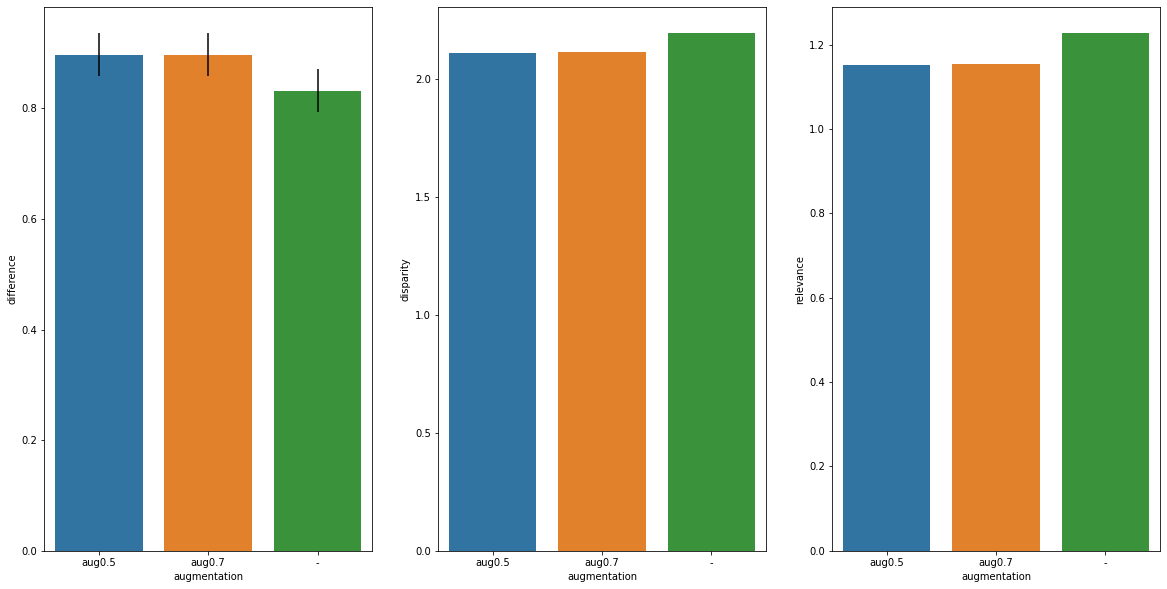

In [257]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('augmentation')
means = groups['difference'].mean()
m1 = means['aug0.5']
n1 = len(groups.get_group('aug0.5'))
m2 = means['aug0.7']
n2 = len(groups.get_group('aug0.7'))
m3 = means['-']
n3 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='augmentation', y='difference',ci=None, yerr=[c1,c2,c3], data=lambdata,ax=axs[0])
sns.barplot(x='augmentation', y='disparity', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='augmentation', y='relevance', ci=None, data=lambdata, ax=axs[2])


<AxesSubplot:xlabel='val_metric', ylabel='relevance'>

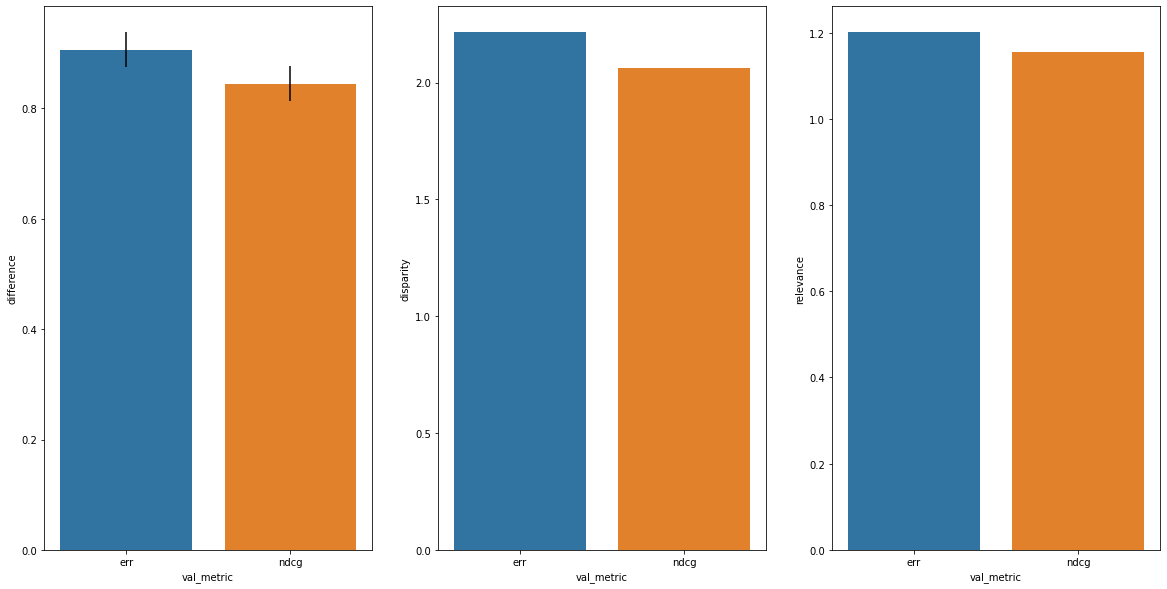

In [258]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('val_metric')
means = groups['difference'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)

ymax = groups[['difference','disparity','relevance']].mean().max().max() + 0.2
fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='val_metric', y='difference',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='val_metric', y='disparity', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='val_metric', y='relevance', ci=None, data=lambdata, ax=axs[2])

<AxesSubplot:xlabel='fm_yes_no', ylabel='relevance'>

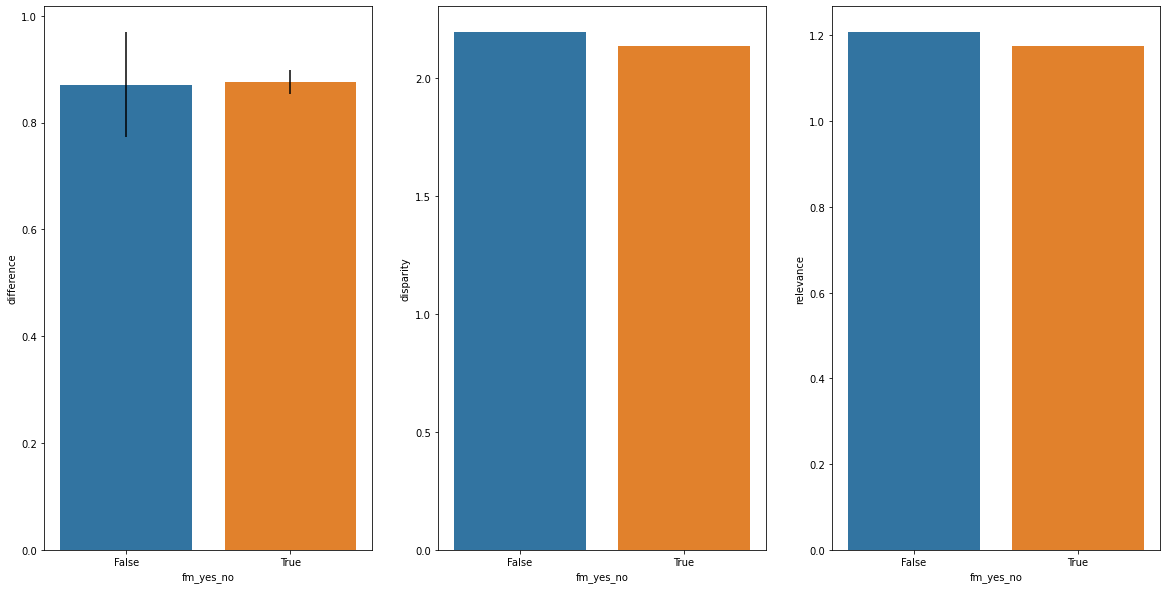

In [259]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('fm_yes_no')
means = groups['difference'].mean()
m1 = means[False]
n1 = len(groups.get_group(False))
m2 = means[True]
n2 = len(groups.get_group(True))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='fm_yes_no', y='difference',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='fm_yes_no', y='disparity', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='fm_yes_no', y='relevance', ci=None, data=lambdata, ax=axs[2])

### ANOVA of all main factors vs EEL_ind

We only have one replication per cell so we can't look at interactions.

In [260]:
def full_eval_run(ivs, dv, data):
    ivs_for_formula = [f'C({iv})' for iv in ivs]
    formula = f"{dv} ~ {' + '.join(ivs_for_formula)}"
    lm = ols(formula, data).fit()
    anova = anova_lm(lm)
    print(anova)
    

In [261]:
formula = "difference_ind ~ C(augmentation) + C(fm_yes_no) + C(val_metric) + C(qid)"
lm = ols(formula, lambdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,1.78448,0.89224,6.65212,0.00132
C(fm_yes_no),1.00000,1.48403,1.48403,11.06424,0.00089
C(val_metric),1.00000,4.21711,4.21711,31.44082,0.00000
C(qid),19.00000,172.06359,9.05598,67.51725,0.00000
Residual,2256.00000,302.59359,0.13413,NaN,NaN


#### ANOVA effect sizes

In [262]:
def print_etasq(factor):
    ss_effect = anova_lm(lm).sum_sq.loc[f'C({factor})']
    ss_error = anova_lm(lm).sum_sq.loc['Residual']
    ss_total = anova_lm(lm).sum_sq.sum()

    print(factor)
    print(f"eta-squared\teta-squared partial")
    print(f"{eta_squared(ss_effect, ss_total)}\t\t\t{eta_squared_partial(ss_effect, ss_error)}")
    print()

In [263]:
print_etasq('augmentation')
print_etasq('val_metric')
print_etasq('fm_yes_no')
print_etasq('qid')

augmentation
eta-squared	eta-squared partial
0.0037			0.00586

val_metric
eta-squared	eta-squared partial
0.00875			0.01374

fm_yes_no
eta-squared	eta-squared partial
0.00308			0.00488

qid
eta-squared	eta-squared partial
0.35687			0.3625



#### Tukey HSD

In [264]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['augmentation'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     - aug0.5   0.0165 0.7424 -0.0387 0.0718  False
     - aug0.7   0.0659 0.0145  0.0106 0.1211   True
aug0.5 aug0.7   0.0493 0.0913 -0.0059 0.1046  False
---------------------------------------------------


In [265]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['fm_yes_no'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 False   True  -0.1143 0.0081 -0.1987 -0.0298   True
----------------------------------------------------


In [266]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lambdata['difference_ind'], groups=lambdata['val_metric'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   err   ndcg   -0.086 0.001 -0.1236 -0.0484   True
---------------------------------------------------


In [267]:
print(len(experiments))
len(experiments.drop_duplicates())

67280


67280

#### cohen's d

In [268]:
means = lambdata.groupby('augmentation')['difference_ind'].mean()
means

augmentation
-        1.41906
aug0.5   1.43558
aug0.7   1.48492
Name: difference_ind, dtype: float64

In [269]:
# augmentation
means = lambdata.groupby('augmentation')['difference_ind'].mean()
m1 = means['-']
m2 = means['aug0.7']
m3 = means['aug0.5']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


0.179821829458751
0.04511761759520932
0.1347042118635417


In [270]:
# feature_method
means = lambdata.groupby('fm_yes_no')['difference_ind'].mean()
m1 = means[True]
m2 = means[False]
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.3119684765614529


In [271]:
# val_metric
means = lambdata.groupby('val_metric')['difference_ind'].mean()
m1 = means['ndcg']
m2 = means['err']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.23486023311051413


ALL the effects are small!

#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='augmentation', ylabel='relevance_ind'>

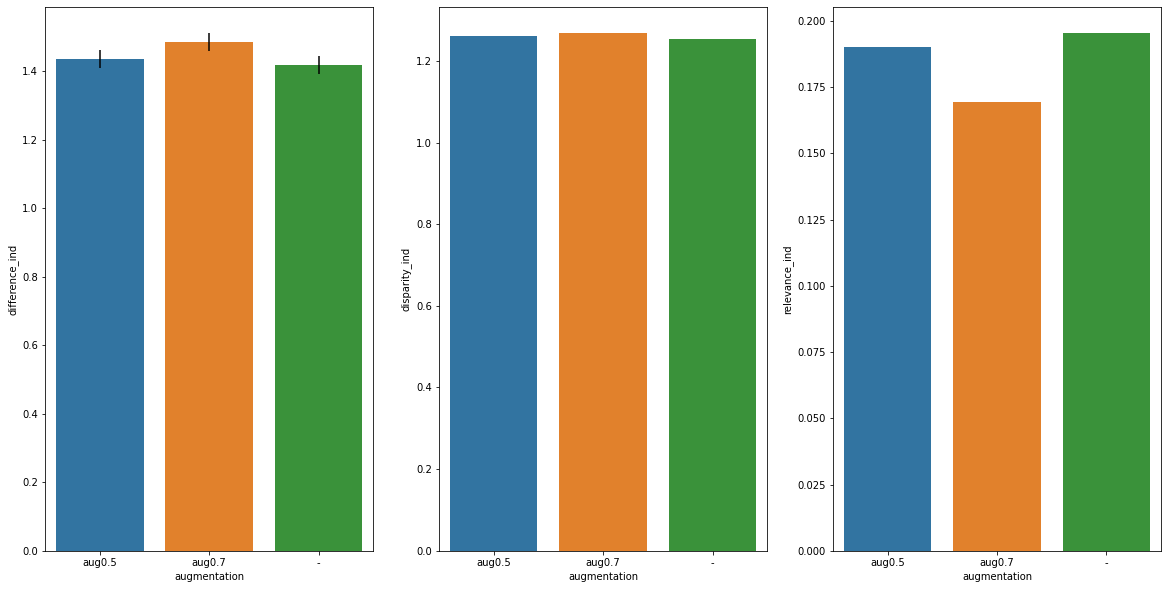

In [272]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('augmentation')
means = groups['difference_ind'].mean()
m1 = means['aug0.5']
n1 = len(groups.get_group('aug0.5'))
m2 = means['aug0.7']
n2 = len(groups.get_group('aug0.7'))
m3 = means['-']
n3 = len(groups.get_group('-'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='augmentation', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=lambdata,ax=axs[0])
sns.barplot(x='augmentation', y='disparity_ind', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='augmentation', y='relevance_ind', ci=None, data=lambdata, ax=axs[2])


<AxesSubplot:xlabel='val_metric', ylabel='relevance_ind'>

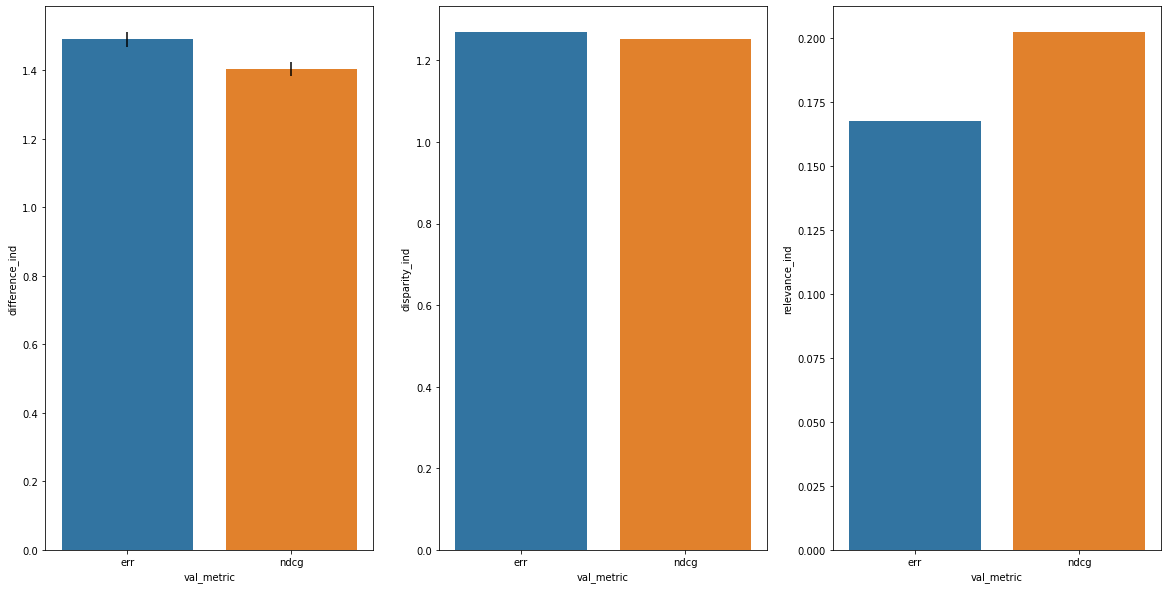

In [273]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('val_metric')
means = groups['difference_ind'].mean()
m1 = means['err']
n1 = len(groups.get_group('err'))
m2 = means['ndcg']
n2 = len(groups.get_group('ndcg'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)

ymax = groups[['difference','disparity','relevance']].mean().max().max() + 0.2
fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='val_metric', y='difference_ind',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='val_metric', y='disparity_ind', ci=None, data=lambdata, ax=axs[1])
sns.barplot(x='val_metric', y='relevance_ind', ci=None, data=lambdata, ax=axs[2])

<AxesSubplot:xlabel='fm_yes_no', ylabel='relevance_ind'>

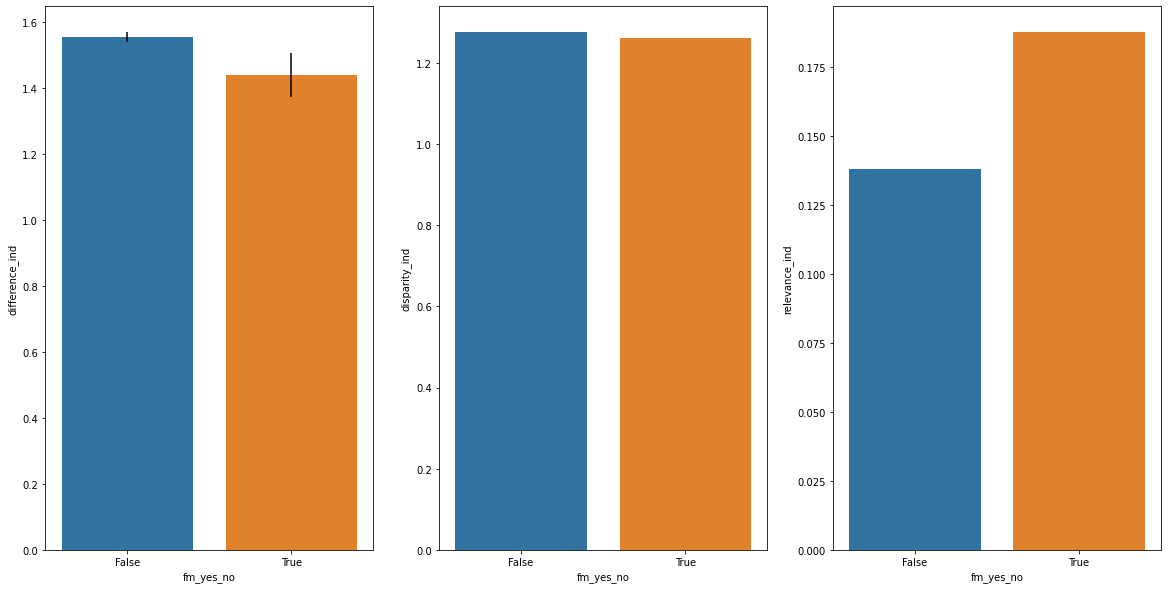

In [274]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lambdata.groupby('fm_yes_no')
means = groups['difference_ind'].mean()
m1 = means[False]
n1 = len(groups.get_group(True))
m2 = means[True]
n2 = len(groups.get_group(False))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='fm_yes_no', y='difference_ind',ci=None, yerr=[c1,c2], data=lambdata,ax=axs[0])
sns.barplot(x='fm_yes_no', y='disparity_ind',ci=None, data=lambdata,ax=axs[1])
sns.barplot(x='fm_yes_no', y='relevance_ind',ci=None, data=lambdata,ax=axs[2])


### ANOVA feature_method vs EEL_ind
Do it only on the data that has good values for the other factors?

In [275]:
ld_sub = lambdata[(lambdata.augmentation == '-') & (lambdata.val_metric == 'ndcg')]

formula = "difference_ind ~ C(fm_yes_no) + C(qid)"
lm = ols(formula, ld_sub).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(fm_yes_no),1.00000,0.00017,0.00017,0.00105,0.97417
C(qid),19.00000,37.47697,1.97247,12.16365,0.00000
Residual,359.00000,58.21587,0.16216,NaN,NaN


In [276]:
9.741671e-01

0.9741671

In the subset of data with the best ndcg and best augmentation there is no significant effect of feature method.

#### Data with feature selection

In [277]:
test = lambdata.drop('fm_yes_no',axis=1)
test['fm'] = test.apply(lambda df: '_'.join([df.feature_method,df.num_features,df.balancing_factor]),axis=1)
test = test [['difference_ind','disparity_ind','relevance_ind','qid','augmentation','val_metric','feature_method','num_features','balancing_factor','fm']]
test = test.drop_duplicates()
test


,difference_ind,disparity_ind,relevance_ind,qid,augmentation,val_metric,feature_method,num_features,balancing_factor,fm
0,1.68645,1.32943,0.04198,3462,aug0.5,err,mpt,10,0.1,mpt_10_0.1
1,1.90473,1.32943,0.10384,8940,aug0.5,err,mpt,10,0.1,mpt_10_0.1
2,1.53864,1.31771,0.06697,10795,aug0.5,err,mpt,10,0.1,mpt_10_0.1
3,1.46067,1.32943,0.01519,12073,aug0.5,err,mpt,10,0.1,mpt_10_0.1
4,2.07945,1.33332,0.01797,12096,aug0.5,err,mpt,10,0.1,mpt_10_0.1
...,...,...,...,...,...,...,...,...,...,...
2275,1.76113,1.33327,0.00656,64062,-,ndcg,-,-,-,-_-_-
2276,0.52595,1.08236,0.66969,66637,-,ndcg,-,-,-,-_-_-
2277,0.59773,1.08333,0.63429,67404,-,ndcg,-,-,-,-_-_-
2278,1.75083,1.31769,0.17458,70673,-,ndcg,-,-,-,-_-_-


In [278]:
formula = "difference_ind ~ C(augmentation) + C(val_metric) + C(feature_method) + C(qid)"
lm = ols(formula, test).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,1.78448,0.89224,6.67398,0.00129
C(val_metric),1.00000,4.21711,4.21711,31.54414,0.00000
C(feature_method),2.00000,2.60883,1.30442,9.75710,0.00006
C(qid),19.00000,172.06359,9.05598,67.73913,0.00000
Residual,2255.00000,301.46878,0.13369,NaN,NaN


In [279]:
print_etasq('feature_method')

feature_method
eta-squared	eta-squared partial
0.00541			0.00858



In [280]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=test['difference_ind'], groups=test['feature_method'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     -    mpt  -0.1371 0.0055 -0.2406 -0.0335   True
     -    msd  -0.0914 0.0962  -0.195  0.0121  False
   mpt    msd   0.0456 0.0545 -0.0007   0.092  False
----------------------------------------------------


In [281]:
# augmentation
means = test.groupby('feature_method')['difference_ind'].mean()
m1 = means['-']
m2 = means['mpt']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.3748920698787504


<AxesSubplot:xlabel='feature_method', ylabel='relevance_ind'>

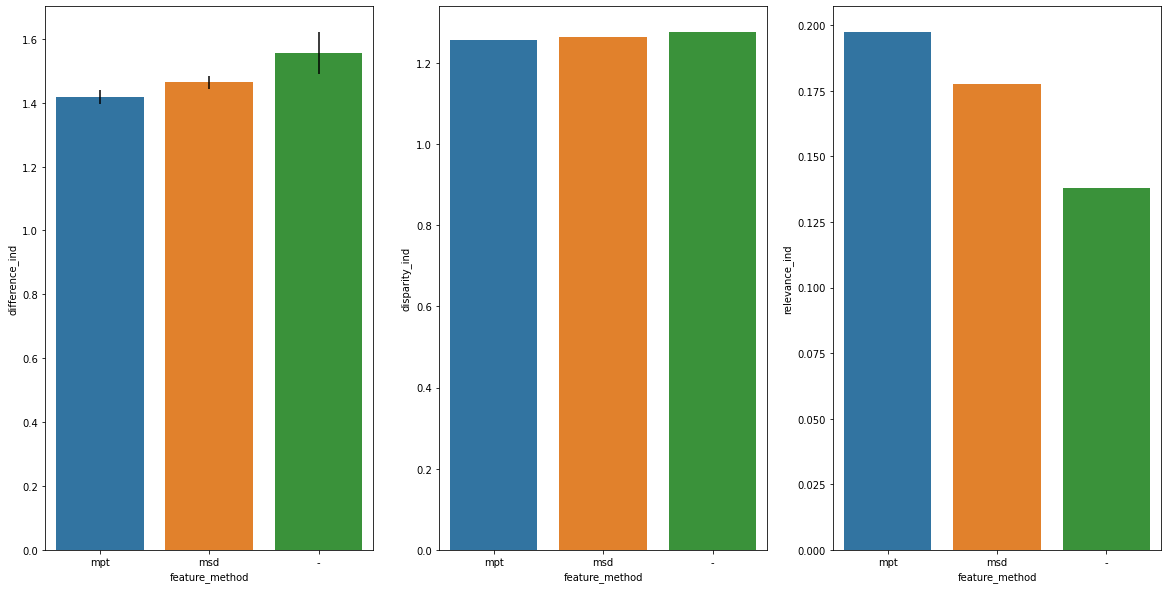

In [282]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = test.groupby('feature_method')
means = groups['difference_ind'].mean()
m3 = means['-']
n3 = len(groups.get_group('-'))
m1 = means['mpt']
n1 = len(groups.get_group('mpt'))
m2 = means['msd']
n2 = len(groups.get_group('msd'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='feature_method', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=test,ax=axs[0])
sns.barplot(x='feature_method', y='disparity_ind', ci=None, data=test, ax=axs[1])
sns.barplot(x='feature_method', y='relevance_ind', ci=None, data=test, ax=axs[2])


In [283]:
formula = "difference_ind ~ C(augmentation) + C(val_metric) + C(num_features) + C(balancing_factor) + C(qid)"
lm = ols(formula, test[test.feature_method == 'mpt']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,1.20227,0.60114,4.43508,0.01208
C(val_metric),1.00000,3.08481,3.08481,22.75914,0.00000
C(num_features),2.00000,0.06930,0.03465,0.25564,0.77447
C(balancing_factor),2.00000,1.22172,0.61086,4.50683,0.01125
C(qid),19.00000,82.47734,4.34091,32.02647,0.00000
Residual,1053.00000,142.72511,0.13554,NaN,NaN


In [284]:
print_etasq('balancing_factor')

balancing_factor
eta-squared	eta-squared partial
0.00529			0.00849



In [285]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=test[test.feature_method == 'mpt']['difference_ind'], groups=test[test.feature_method == 'mpt']['balancing_factor'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.1    0.5  -0.0665 0.1302 -0.1472 0.0143  False
   0.1    0.9  -0.0754 0.0733 -0.1561 0.0054  False
   0.5    0.9  -0.0089    0.9 -0.0897 0.0719  False
---------------------------------------------------


##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='balancing_factor', ylabel='relevance_ind'>

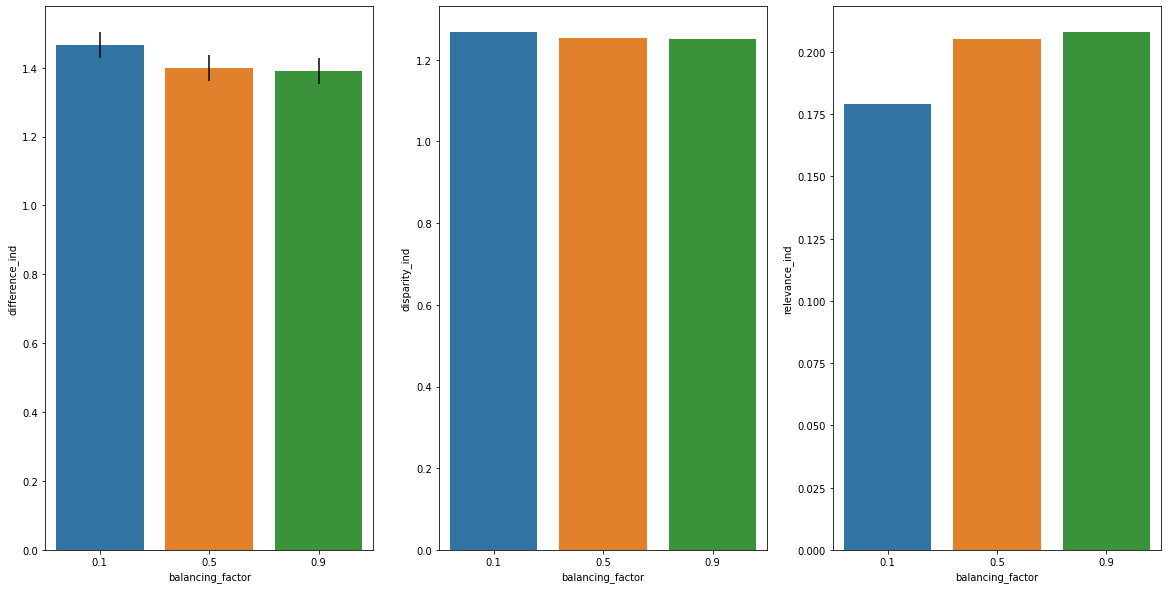

In [286]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = test[test.feature_method == 'mpt'].groupby('balancing_factor')
means = groups['difference_ind'].mean()
m1 = means['0.1']
n1 = len(groups.get_group('0.1'))
m2 = means['0.5']
n2 = len(groups.get_group('0.5'))
m3 = means['0.9']
n3 = len(groups.get_group('0.9'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='balancing_factor', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=test[test.feature_method == 'mpt'],ax=axs[0])
sns.barplot(x='balancing_factor', y='disparity_ind', ci=None, data=test[test.feature_method == 'mpt'], ax=axs[1])
sns.barplot(x='balancing_factor', y='relevance_ind', ci=None, data=test[test.feature_method == 'mpt'], ax=axs[2])


## Are the values of the base versions of LM improved by post processing with RFR?

In [287]:
lmrfr = experiments[((experiments.ranker == 'rfr') & (experiments.source == 'lambdamart_ndcg_noaug_nofeat')) | ((experiments.ranker == 'lambdamart') & (experiments.feature_method == '-') & (experiments.augmentation == '-') & (experiments.val_metric == 'ndcg'))]
lmrfr = lmrfr.reset_index(drop=True)
lmrfr

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.57712,2.79229,1.66427,1.68622,1.32940,0.04208,0.08763,3462,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
1,1.21999,2.38827,1.02972,1.98201,1.33236,0.06666,0.04457,8940,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2,0.46480,2.26661,1.50561,1.61721,1.32943,0.03354,0.08771,10795,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
3,0.38409,1.38503,0.83105,0.96625,1.07941,0.13739,0.75455,12073,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
4,0.17772,2.82322,2.18903,2.05038,1.33309,0.03239,0.02188,12096,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.38618,2.47630,1.60279,0.37829,0.20984,0.13627,0.27761,64062,rfr,lambdamart_ndcg_noaug_nofeat,doc,-,-,-,-,-,-,-,-,doc_-
96,0.07816,2.55821,2.16614,0.55271,0.39464,0.31245,0.32153,66637,rfr,lambdamart_ndcg_noaug_nofeat,doc,-,-,-,-,-,-,-,-,doc_-
97,0.20991,1.50974,1.50326,0.55891,0.39690,0.31049,0.31693,67404,rfr,lambdamart_ndcg_noaug_nofeat,doc,-,-,-,-,-,-,-,-,doc_-
98,0.25001,1.36099,1.01830,0.54435,0.33733,0.28764,0.30290,70673,rfr,lambdamart_ndcg_noaug_nofeat,doc,-,-,-,-,-,-,-,-,doc_-


In [290]:
lmrfr.groupby('ranker').difference.mean()

ranker
lambdamart   0.76191
rfr          0.48253
Name: difference, dtype: float64

In [291]:
formula = "difference ~ C(ranker) + C(qid)"
lm = ols(formula, lmrfr).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),1.00000,1.24887,1.24887,27.19939,0.00000
C(qid),19.00000,36.38602,1.91505,41.70828,0.00000
Residual,79.00000,3.62732,0.04592,NaN,NaN


In [292]:
print_etasq('ranker')

ranker
eta-squared	eta-squared partial
0.03027			0.25612



In [293]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference'], groups=lmrfr['ranker'], alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1   group2 meandiff p-adj   lower  upper  reject
-------------------------------------------------------
lambdamart    rfr  -0.2794 0.0834 -0.5964 0.0376  False
-------------------------------------------------------


In [294]:
means = lmrfr.groupby('ranker')['difference'].mean()
m1 = means['lambdamart']
m2 = means['rfr']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


1.3038258778691592


<AxesSubplot:xlabel='ranker', ylabel='relevance'>

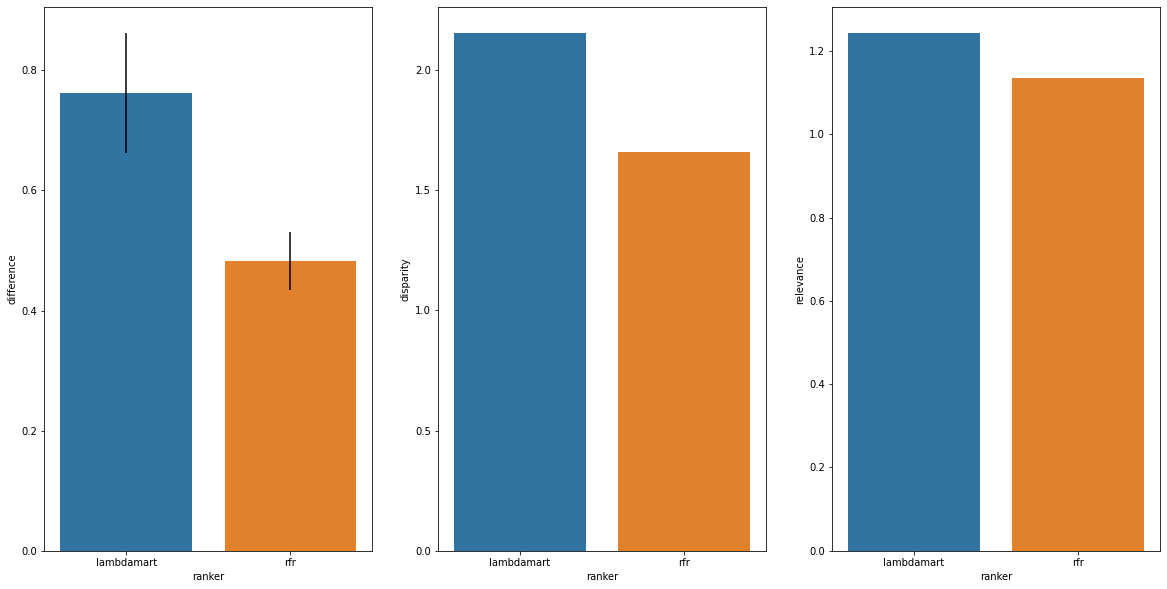

In [295]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr.groupby('ranker')
means = groups['difference'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['rfr']
n2 = len(groups.get_group('rfr'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference',ci=None, yerr=[c1,c2], data=lmrfr,ax=axs[0])
sns.barplot(x='ranker', y='disparity', ci=None, data=lmrfr, ax=axs[1])
sns.barplot(x='ranker', y='relevance', ci=None, data=lmrfr, ax=axs[2])


In [296]:
formula = "difference ~ C(gr) + C(qid)"
lm = ols(formula, lmrfr[lmrfr.ranker == 'rfr']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.04162,0.01387,0.54987,0.65028
C(qid),19.00000,30.15118,1.58690,62.90267,0.00000
Residual,57.00000,1.43799,0.02523,NaN,NaN


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [297]:
lmrfr[lmrfr.ranker == 'rfr'].groupby('gr')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
gr,,,
auth_ind,0.49482,1.65549,1.12694
auth_none,0.49510,1.65646,1.12728
auth_one,0.49716,1.66341,1.12972
doc_-,0.44306,1.66905,1.15959


The base config of LambdaMart performs best in terms of group difference.

<AxesSubplot:xlabel='gr', ylabel='relevance'>

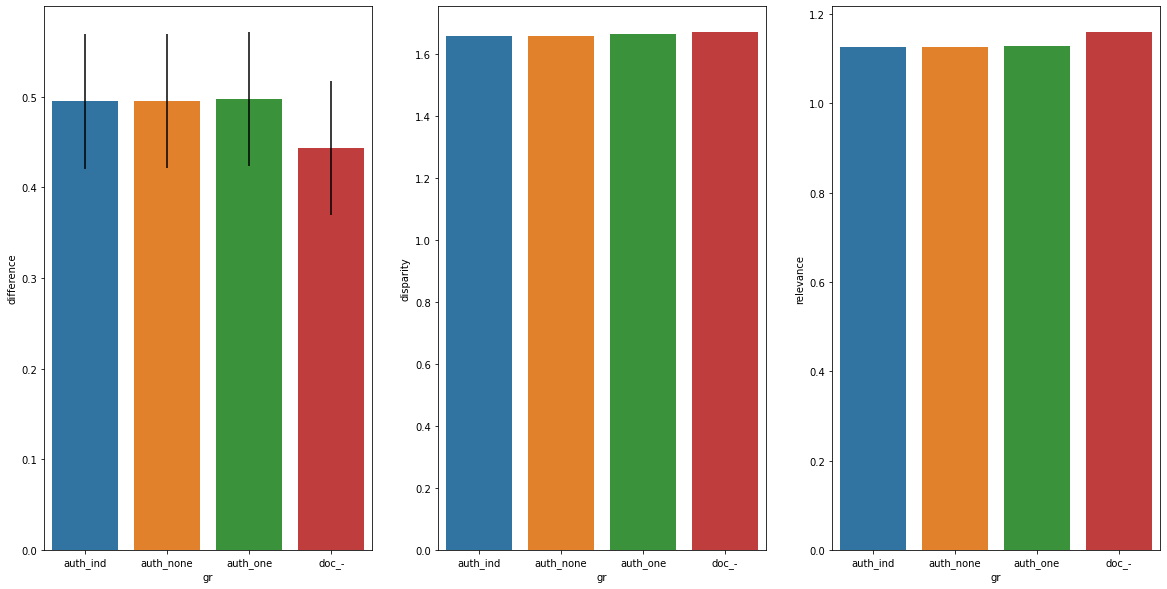

In [300]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr[lmrfr.ranker == 'rfr'].groupby('gr')
means = groups['difference'].mean()
m1 = means['auth_ind']
n1 = len(groups.get_group('auth_ind'))
m2 = means['auth_none']
n2 = len(groups.get_group('auth_none'))
m3 = means['auth_one']
n3 = len(groups.get_group('auth_one'))
m4 = means['doc_-']
n4 = len(groups.get_group('doc_-'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c4 = ci(m4, n4, ms_error)
c3 = ci(m3, n3, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=lmrfr[lmrfr.ranker == 'rfr'],ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[2])


#### jfjfjf

In [301]:
formula = "difference_ind ~ C(ranker) + C(qid)"
lm = ols(formula, lmrfr).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),1.00000,11.33260,11.33260,190.69293,0.00000
C(qid),19.00000,7.84813,0.41306,6.95052,0.00000
Residual,79.00000,4.69485,0.05943,NaN,NaN


In [302]:
print_etasq('ranker')

ranker
eta-squared	eta-squared partial
0.47465			0.70707



In [303]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr['difference_ind'], groups=lmrfr['ranker'], alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1   group2 meandiff p-adj  lower   upper  reject
-------------------------------------------------------
lambdamart    rfr  -0.8416 0.001 -1.0191 -0.6641   True
-------------------------------------------------------


In [304]:
means = lmrfr.groupby('ranker')['difference_ind'].mean()
m1 = means['lambdamart']
m2 = means['rfr']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


3.4522902813180014


<AxesSubplot:xlabel='ranker', ylabel='relevance_ind'>

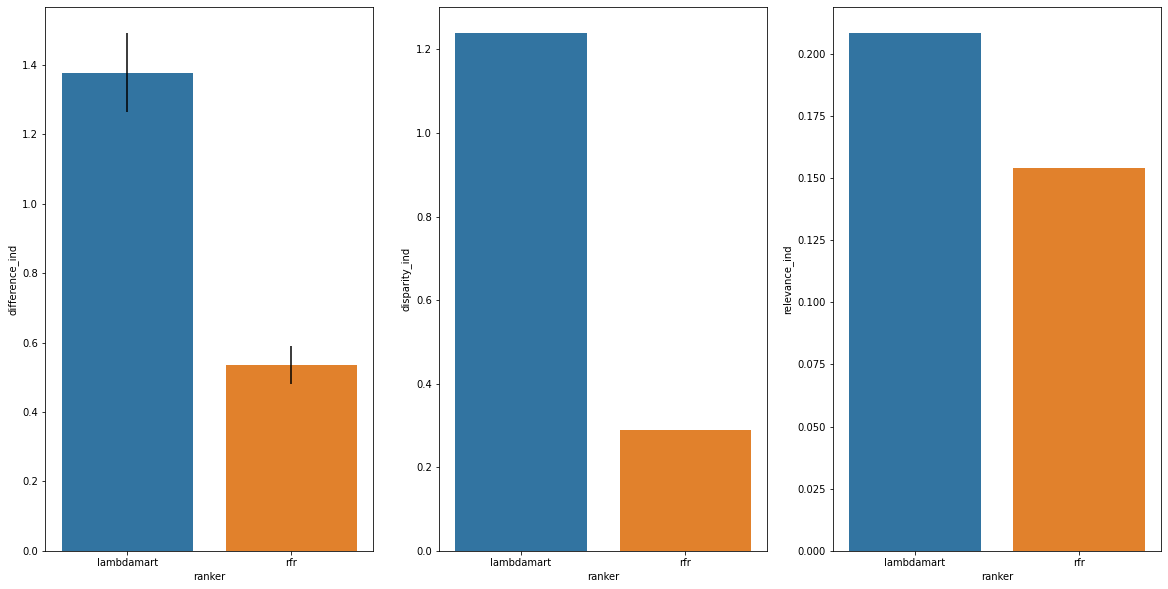

In [305]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr.groupby('ranker')
means = groups['difference_ind'].mean()
m1 = means['lambdamart']
n1 = len(groups.get_group('lambdamart'))
m2 = means['rfr']
n2 = len(groups.get_group('rfr'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference_ind',ci=None, yerr=[c1,c2], data=lmrfr,ax=axs[0])
sns.barplot(x='ranker', y='disparity_ind', ci=None, data=lmrfr, ax=axs[1])
sns.barplot(x='ranker', y='relevance_ind', ci=None, data=lmrfr, ax=axs[2])


In [308]:
formula = "difference_ind ~ C(gr) + C(qid)"
lm = ols(formula, lmrfr[lmrfr.ranker == 'rfr']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.08669,0.02890,3.12262,0.03284
C(qid),19.00000,6.41730,0.33775,36.49645,0.00000
Residual,57.00000,0.52750,0.00925,NaN,NaN


In [309]:
print_etasq('gr')

gr
eta-squared	eta-squared partial
0.01233			0.14115



In [310]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=lmrfr[lmrfr.ranker == 'rfr']['difference_ind'], groups=lmrfr[lmrfr.ranker == 'rfr']['gr'], alpha=0.05)
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
 auth_ind auth_none   0.0002    0.9 -0.2509 0.2513  False
 auth_ind  auth_one    0.003    0.9 -0.2481 0.2541  False
 auth_ind     doc_-  -0.0749 0.8454  -0.326 0.1762  False
auth_none  auth_one   0.0029    0.9 -0.2482  0.254  False
auth_none     doc_-  -0.0751 0.8444 -0.3262  0.176  False
 auth_one     doc_-  -0.0779 0.8277  -0.329 0.1732  False
---------------------------------------------------------


In [71]:
means = lmrfr[lmrfr.ranker == 'rfr'].groupby('gr')['difference_ind'].mean()
m1 = means['auth']
m2 = means['doc']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.8033853714194148


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [72]:
lmrfr[lmrfr.ranker == 'rfr'].groupby('group')[['difference_ind','disparity_ind','relevance_ind']].mean()

,difference_ind,disparity_ind,relevance_ind
group,,,
auth,0.55517,0.30032,0.15025
doc,0.47920,0.25456,0.16535


The base config of LambdaMart performs best in terms of group difference.

<AxesSubplot:xlabel='gr', ylabel='relevance_ind'>

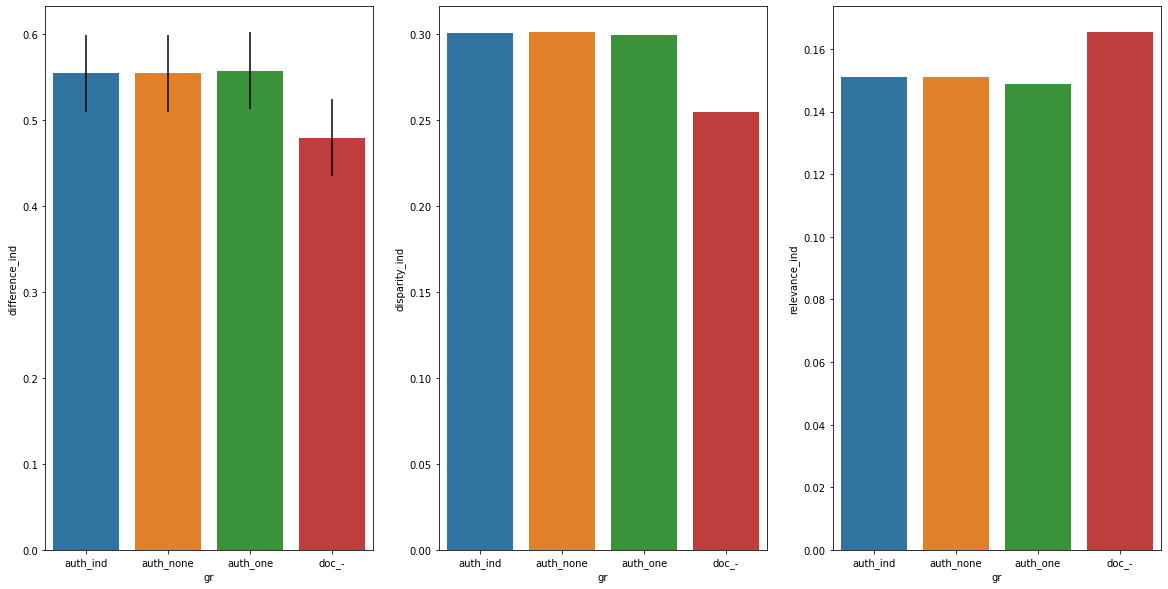

In [316]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = lmrfr[lmrfr.ranker == 'rfr'].groupby('gr')
means = groups['difference_ind'].mean()
m1 = means['auth_ind']
n1 = len(groups.get_group('auth_ind'))
m2 = means['auth_none']
n2 = len(groups.get_group('auth_none'))
m3 = means['auth_one']
n3 = len(groups.get_group('auth_one'))
m4 = means['doc_-']
n4 = len(groups.get_group('doc_-'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c4 = ci(m4, n4, ms_error)
c3 = ci(m3, n3, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='gr', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data=lmrfr[lmrfr.ranker == 'rfr'],ax=axs[0])
sns.barplot(x='gr', y='disparity_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[1])
sns.barplot(x='gr', y='relevance_ind', ci=None, data=lmrfr[lmrfr.ranker == 'rfr'], ax=axs[2])

## Are the values of the base versions of AC improved by our changes?

### Select AC data with KR relevances

In [466]:
ackrdata = experiments[(experiments.ranker == 'ac') & ((experiments.source == 'TEXT_train') | (experiments.source == 'META_train'))]
ackrdata = ackrdata.reset_index(drop=True)
ackrdata.head()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09151,1.73020,1.37603,0.40510,0.11638,0.07613,0.15725,3462,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
1,0.34400,1.36933,0.95825,0.56015,0.30825,0.26554,0.27069,8940,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
2,0.11141,1.77696,1.43747,0.31003,0.11223,0.07853,0.20133,10795,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
3,0.11426,1.09435,0.82062,0.14962,0.09688,0.05444,0.29695,12073,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
4,0.27833,1.33008,1.39215,0.66967,0.18819,0.15030,0.15480,12096,ac,META_train,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind


In [470]:
ackrdata.groupby(['source','group']).mean()

difference  disparity  relevance  difference_ind  disparity_ind  relevance_ind  \
source     group                                                                                   
META_train auth      0.45541    1.62112    1.12945         0.48988        0.22578        0.14562   
           doc       0.42555    1.59146    1.12956         0.45648        0.19549        0.14718   
TEXT_train auth      0.47437    1.64172    1.13027         0.50645        0.23101        0.13996   
           doc       0.43618    1.60544    1.13123         0.46509        0.19491        0.14258   

                    util         qid  
source     group                      
META_train auth  0.23884 39200.95000  
           doc   0.24203 39200.95000  
TEXT_train auth  0.23192 39200.95000  
           doc   0.23638 39200.95000

In [318]:
meta9 = ackrdata[(ackrdata.theta == 9) & (ackrdata.source == 'META_train')].reset_index(drop=True)
meta99 = ackrdata[(ackrdata.theta == 99) & (ackrdata.source == 'META_train')].reset_index(drop=True)
text9 = ackrdata[(ackrdata.theta == 9) & (ackrdata.source == 'TEXT_train')].reset_index(drop=True)
text99 = ackrdata[(ackrdata.theta == 99) & (ackrdata.source == 'TEXT_train')].reset_index(drop=True)
print(len(meta9),len(meta99),len(text9),len(text99))

240 240 240 240


In [319]:
meta9

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.08665,1.67281,1.34976,0.39971,0.10841,0.07484,0.15455,3462,ac,META_train,auth,ind,9.00000,linear,-,-,-,-,-,auth_ind
1,0.33297,1.35401,0.95611,0.56060,0.30670,0.26454,0.26861,8940,ac,META_train,auth,ind,9.00000,linear,-,-,-,-,-,auth_ind
2,0.09178,1.72169,1.41965,0.30120,0.09890,0.07628,0.19658,10795,ac,META_train,auth,ind,9.00000,linear,-,-,-,-,-,auth_ind
3,0.09444,1.00058,0.78365,0.13123,0.07961,0.05500,0.30159,12073,ac,META_train,auth,ind,9.00000,linear,-,-,-,-,-,auth_ind
4,0.27730,1.34047,1.39786,0.67783,0.18395,0.14410,0.14668,12096,ac,META_train,auth,ind,9.00000,linear,-,-,-,-,-,auth_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.26895,2.21533,1.53092,0.33906,0.16846,0.13519,0.27570,64062,ac,META_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
236,0.11966,2.86976,2.30116,0.57956,0.30804,0.25573,0.25940,66637,ac,META_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
237,0.32032,1.41075,1.39856,0.58090,0.30837,0.25522,0.25959,67404,ac,META_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
238,0.42592,1.81070,1.15520,0.64131,0.21334,0.17716,0.18230,70673,ac,META_train,doc,-,9.00000,min,-,-,-,-,-,doc_-


### ANOVA main factors vs EEL

In [481]:
formula = "difference ~ C(gr) + C(theta) + C(hfunc)"
lm = ols(formula, ackrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,2.00924,0.66975,2.12524,0.09544
C(theta),1.00000,0.05830,0.05830,0.18499,0.66721
C(hfunc),2.00000,0.12057,0.06028,0.19129,0.82592
Residual,953.00000,300.32773,0.31514,NaN,NaN


#### meta9

In [320]:
formula = "difference ~ C(gr) + C(hfunc)"
lm = ols(formula, meta9).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.61592,0.20531,0.62622,0.59872
C(hfunc),2.00000,0.04633,0.02317,0.07066,0.93180
Residual,234.00000,76.71596,0.32785,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='gr', ylabel='relevance'>

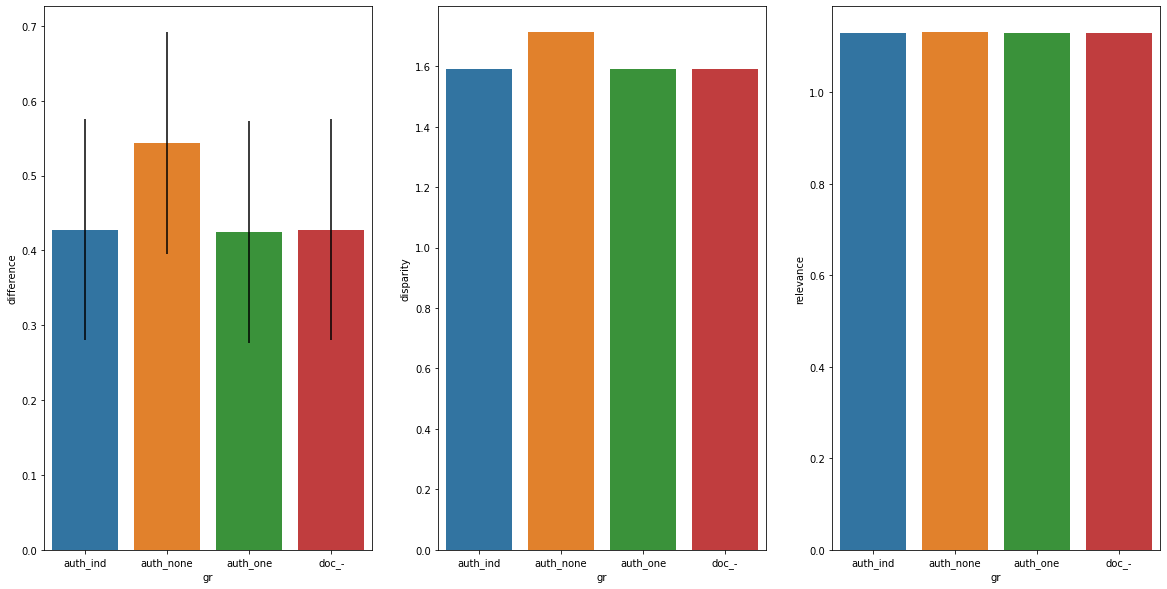

In [321]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('gr')
means = groups['difference'].mean()
m1 = means['auth_ind']
n1 = len(groups.get_group('auth_ind'))
m2 = means['auth_none']
n2 = len(groups.get_group('auth_none'))
m3 = means['auth_one']
n3 = len(groups.get_group('auth_one'))
m4 = means['doc_-']
n4 = len(groups.get_group('doc_-'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c4 = ci(m4, n4, ms_error)
c3 = ci(m3, n3, ms_error)





fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=meta9,ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data=meta9, ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data=meta9, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance'>

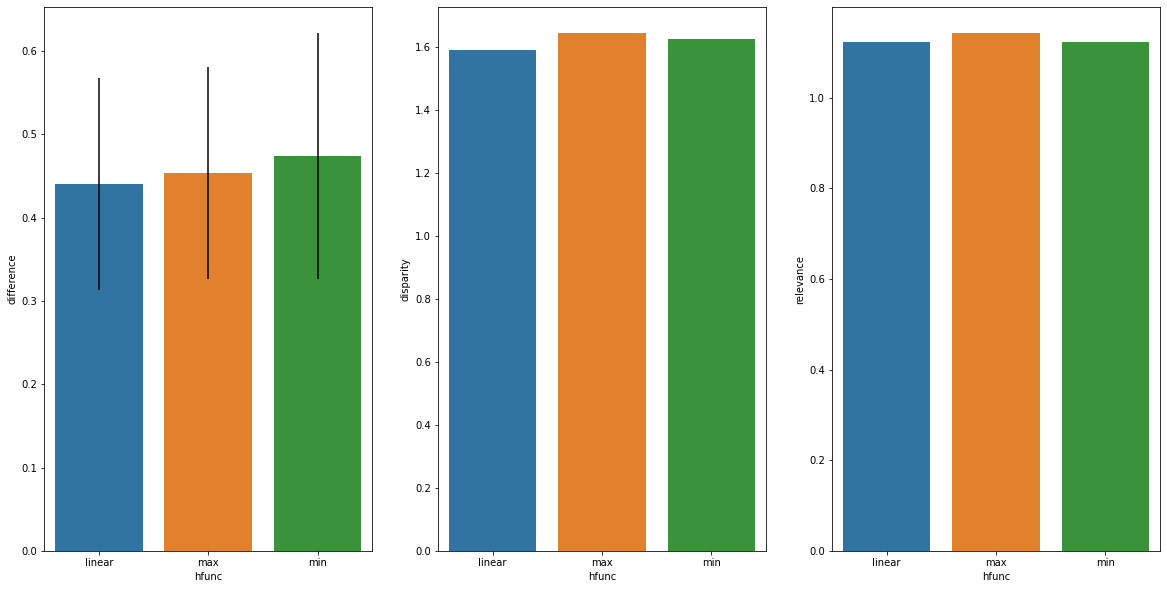

In [322]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('hfunc')
means = groups['difference'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference',ci=None, yerr=[c1,c2,c3], data=meta9,ax=axs[0])
sns.barplot(x='hfunc', y='disparity', ci=None, data=meta9, ax=axs[1])
sns.barplot(x='hfunc', y='relevance', ci=None, data=meta9, ax=axs[2])

In [81]:
print(len(experiments))
len(experiments.drop_duplicates())


67280


67280

#### meta99

In [323]:
formula = "difference ~ C(gr) + C(hfunc)"
lm = ols(formula, meta99).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.21906,0.07302,0.26103,0.85342
C(hfunc),2.00000,0.04355,0.02178,0.07784,0.92513
Residual,234.00000,65.45862,0.27974,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance'>

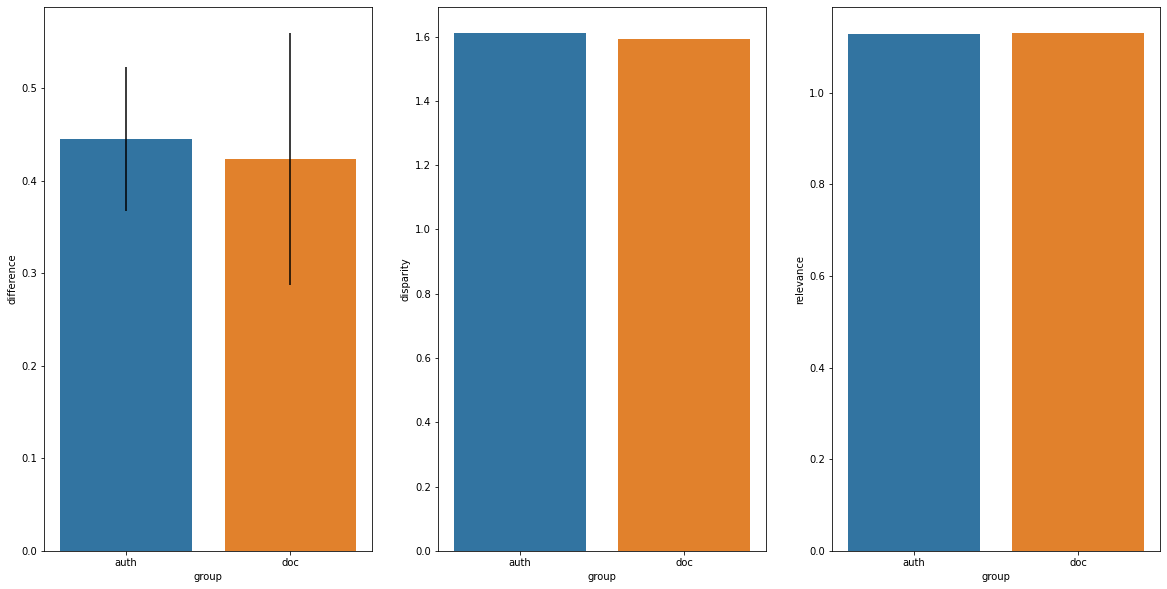

In [83]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('group')
means = groups['difference'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=meta99,ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=meta99, ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=meta99, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance'>

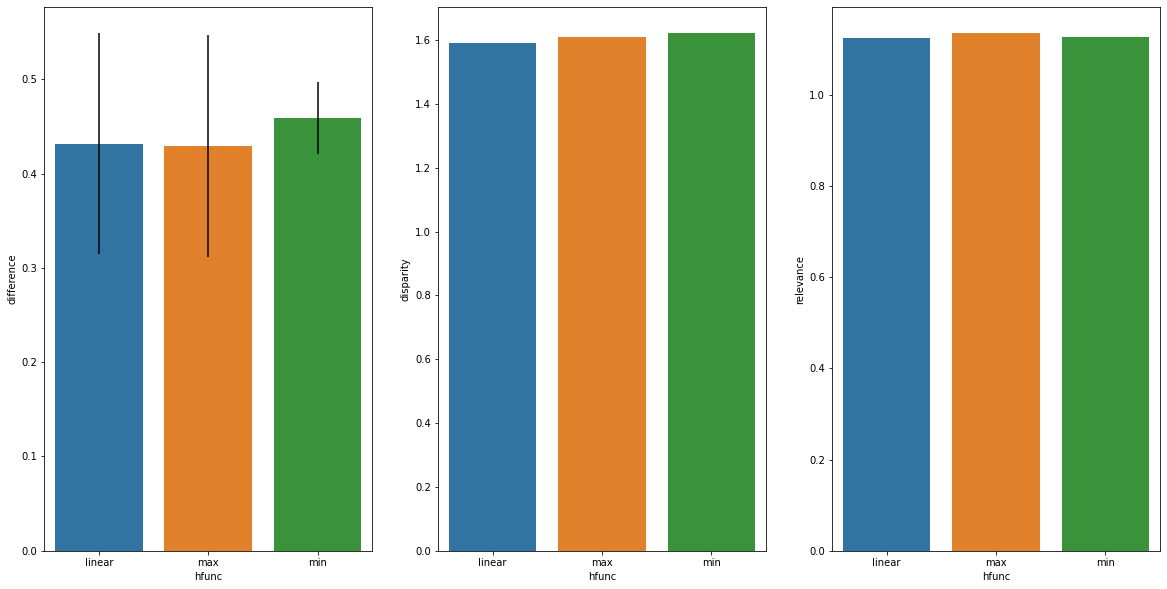

In [84]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('hfunc')
means = groups['difference'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference',ci=None, yerr=[c1,c2,c3], data=meta99,ax=axs[0])
sns.barplot(x='hfunc', y='disparity', ci=None, data=meta99, ax=axs[1])
sns.barplot(x='hfunc', y='relevance', ci=None, data=meta99, ax=axs[2])

#### text9

In [324]:
formula = "difference ~ C(gr) + C(hfunc)"
lm = ols(formula, text9).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.74944,0.24981,0.70479,0.55002
C(hfunc),2.00000,0.03402,0.01701,0.04798,0.95316
Residual,234.00000,82.94110,0.35445,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance'>

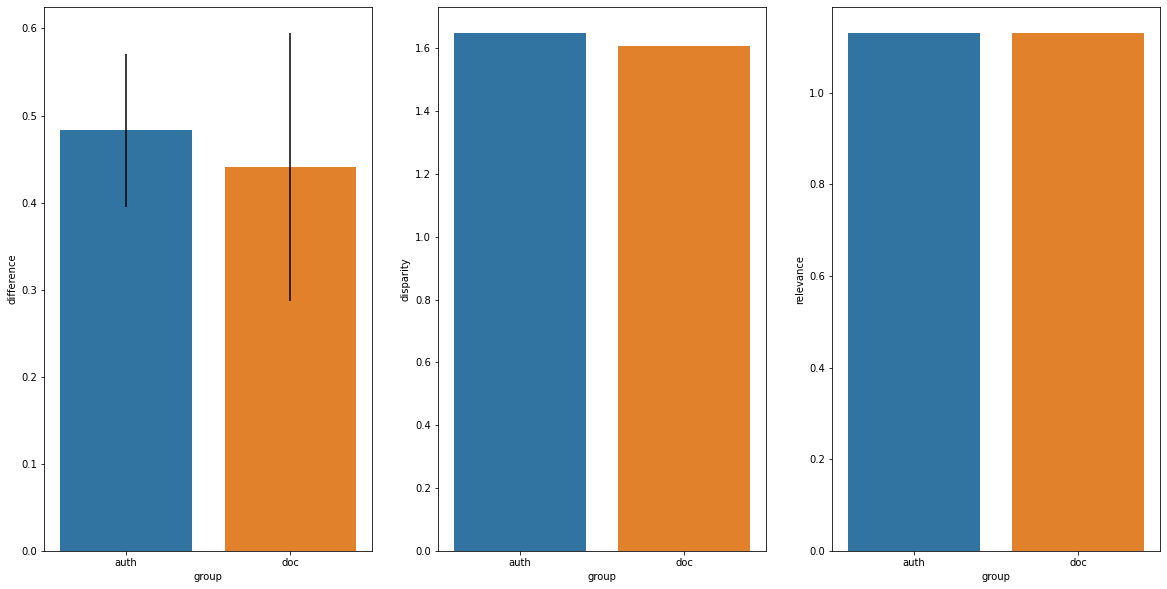

In [86]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('group')
means = groups['difference'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=text9,ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=text9, ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=text9, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance'>

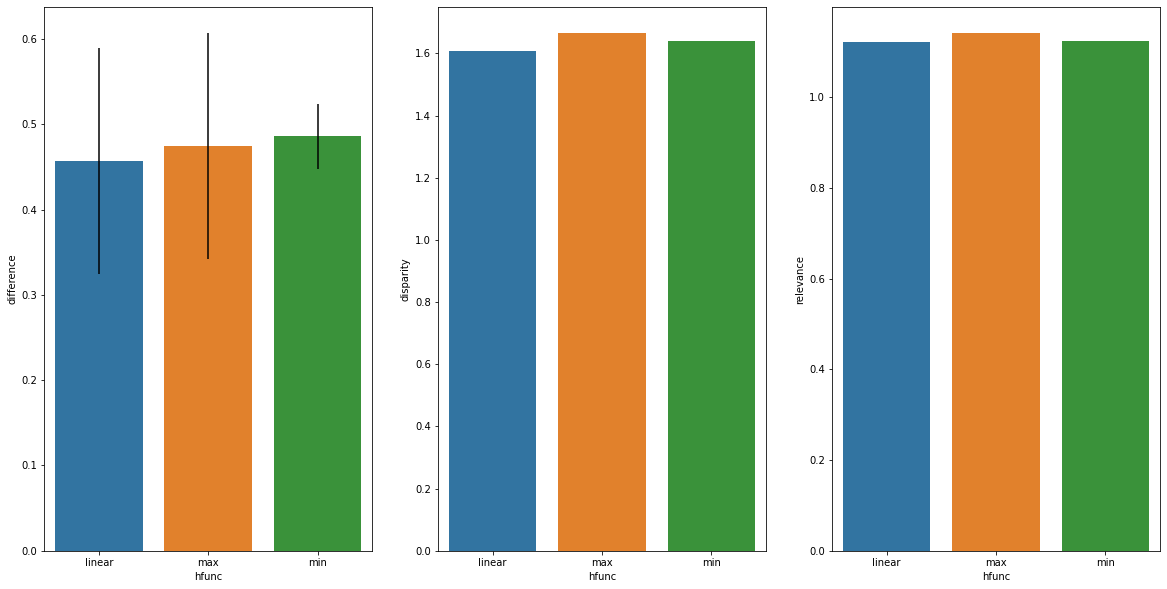

In [87]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('hfunc')
means = groups['difference'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference',ci=None, yerr=[c1,c2,c3], data=text9,ax=axs[0])
sns.barplot(x='hfunc', y='disparity', ci=None, data=text9, ax=axs[1])
sns.barplot(x='hfunc', y='relevance', ci=None, data=text9, ax=axs[2])

#### text99

In [326]:
formula = "difference ~ C(gr) + C(hfunc)"
lm = ols(formula, text99).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.51362,0.17121,0.53391,0.65947
C(hfunc),2.00000,0.01550,0.00775,0.02417,0.97613
Residual,234.00000,75.03606,0.32067,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance'>

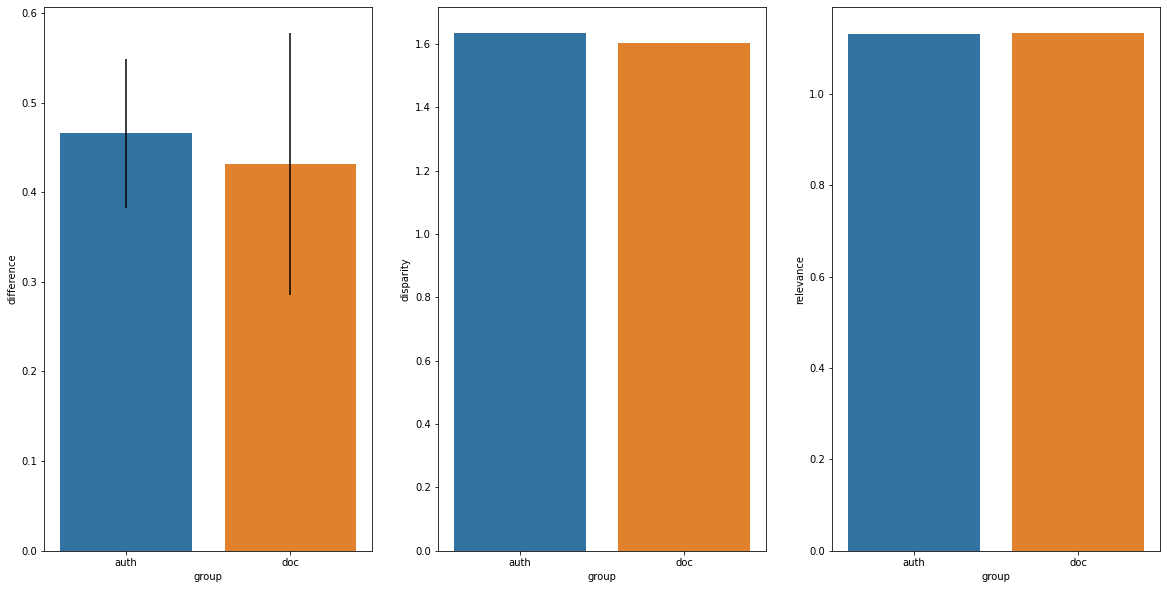

In [89]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('group')
means = groups['difference'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference',ci=None, yerr=[c1,c2], data=text99,ax=axs[0])
sns.barplot(x='group', y='disparity', ci=None, data=text99, ax=axs[1])
sns.barplot(x='group', y='relevance', ci=None, data=text99, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance'>

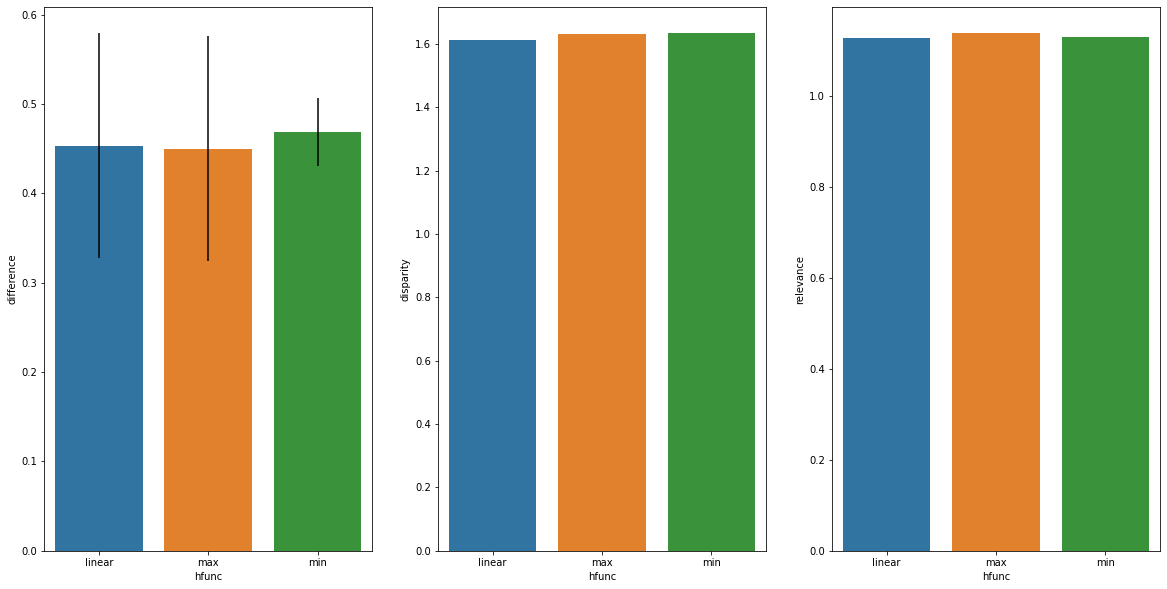

In [90]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('hfunc')
means = groups['difference'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference',ci=None, yerr=[c1,c2,c3], data=text99,ax=axs[0])
sns.barplot(x='hfunc', y='disparity', ci=None, data=text99, ax=axs[1])
sns.barplot(x='hfunc', y='relevance', ci=None, data=text99, ax=axs[2])

### ANOVA main factors vs EEL_ind



#### meta9

In [329]:
formula = "difference_ind ~ C(gr) + C(hfunc)"
lm = ols(formula, meta9).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.47492,0.15831,2.58328,0.05406
C(hfunc),2.00000,0.12203,0.06102,0.99567,0.37104
Residual,234.00000,14.33969,0.06128,NaN,NaN


##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

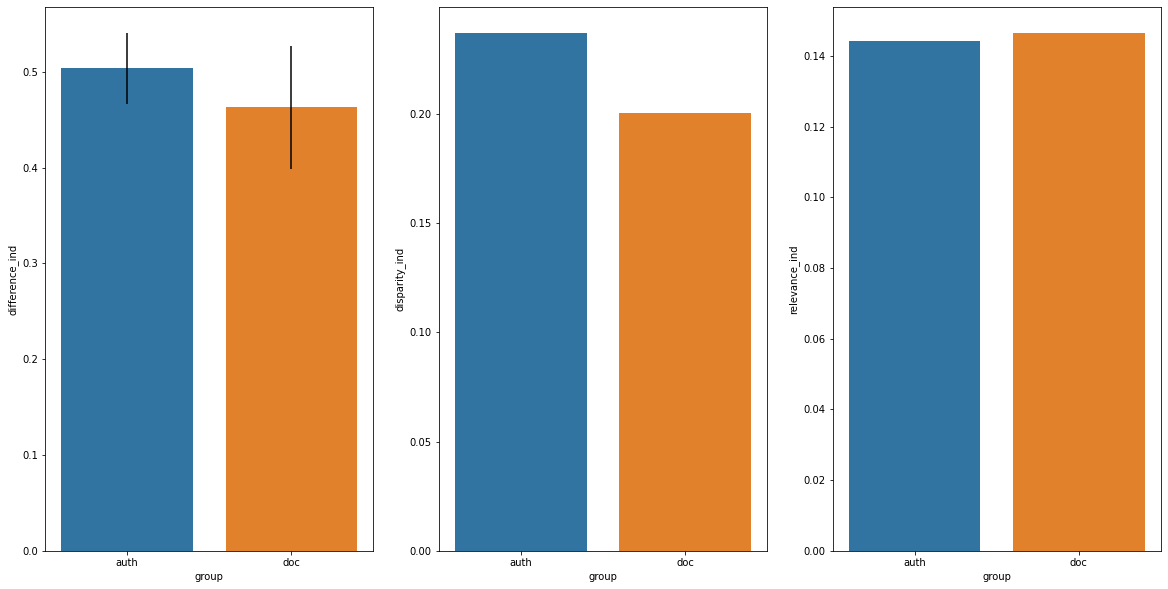

In [92]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=meta9,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=meta9, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=meta9, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

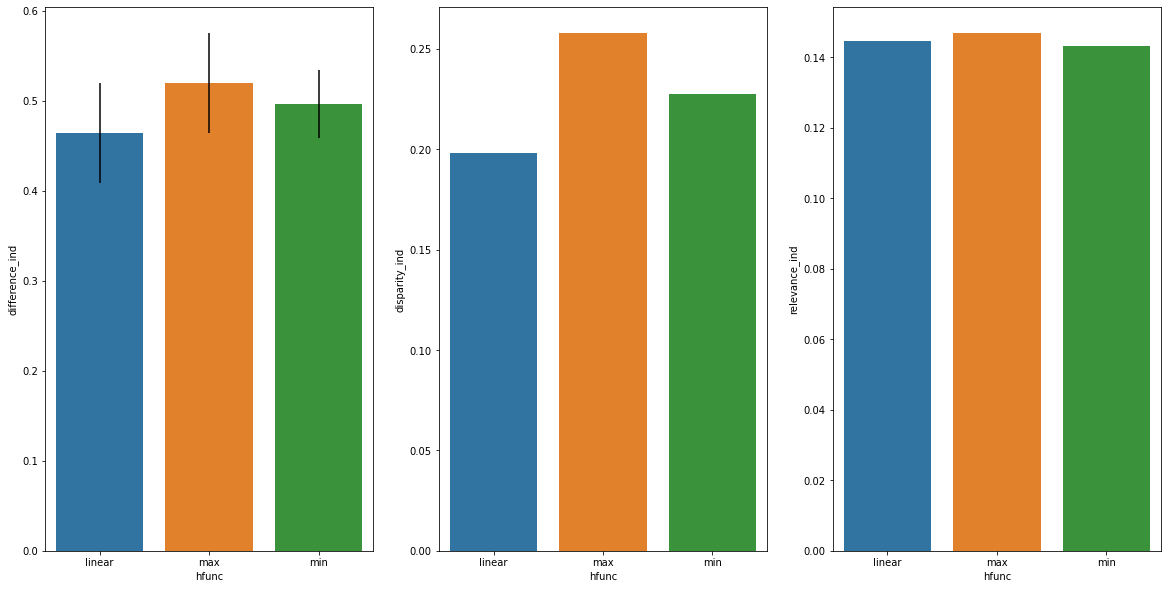

In [93]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta9.groupby('hfunc')
means = groups['difference_ind'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=meta9,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=meta9, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=meta9, ax=axs[2])

#### meta99

In [332]:
formula = "difference ~ C(gr) + C(hfunc)"
lm = ols(formula, meta99).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.21906,0.07302,0.26103,0.85342
C(hfunc),2.00000,0.04355,0.02178,0.07784,0.92513
Residual,234.00000,65.45862,0.27974,NaN,NaN


In [333]:
print_etasq('gr')

gr
eta-squared	eta-squared partial
0.00333			0.00334



In [334]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=meta9['difference_ind'], groups=meta99['gr'], alpha=0.05)
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
 auth_ind auth_none      0.1 0.1229 -0.0169  0.217  False
 auth_ind  auth_one   0.0001    0.9 -0.1168 0.1171  False
 auth_ind     doc_-  -0.0075    0.9 -0.1245 0.1094  False
auth_none  auth_one  -0.0999 0.1236 -0.2168 0.0171  False
auth_none     doc_-  -0.1075  0.084 -0.2245 0.0094  False
 auth_one     doc_-  -0.0077    0.9 -0.1246 0.1093  False
---------------------------------------------------------


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

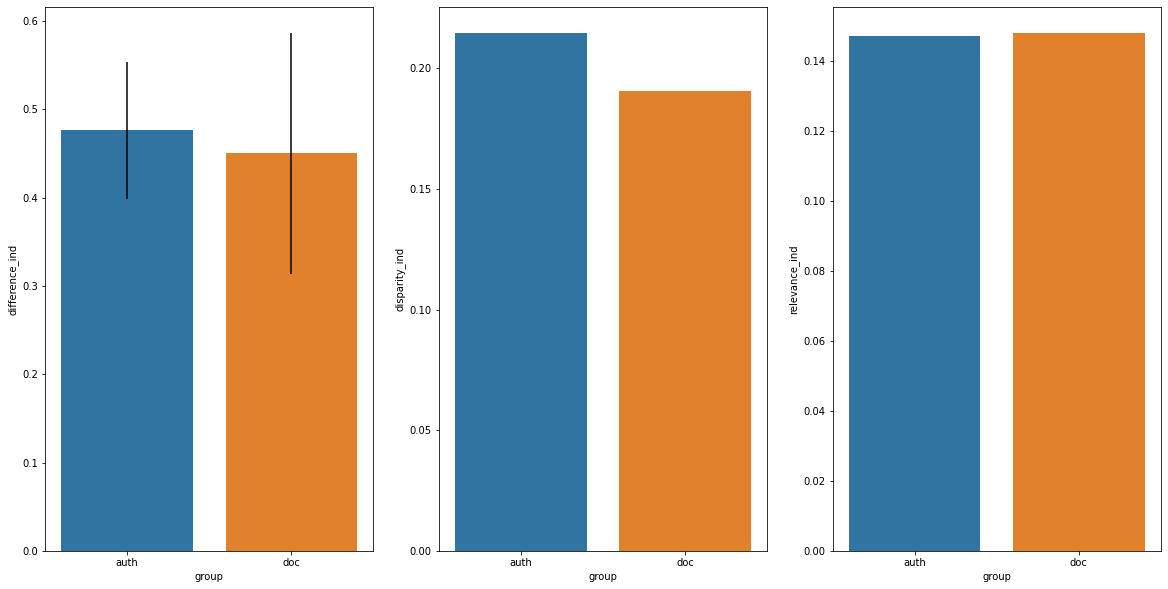

In [95]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=meta99,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=meta99, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=meta99, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

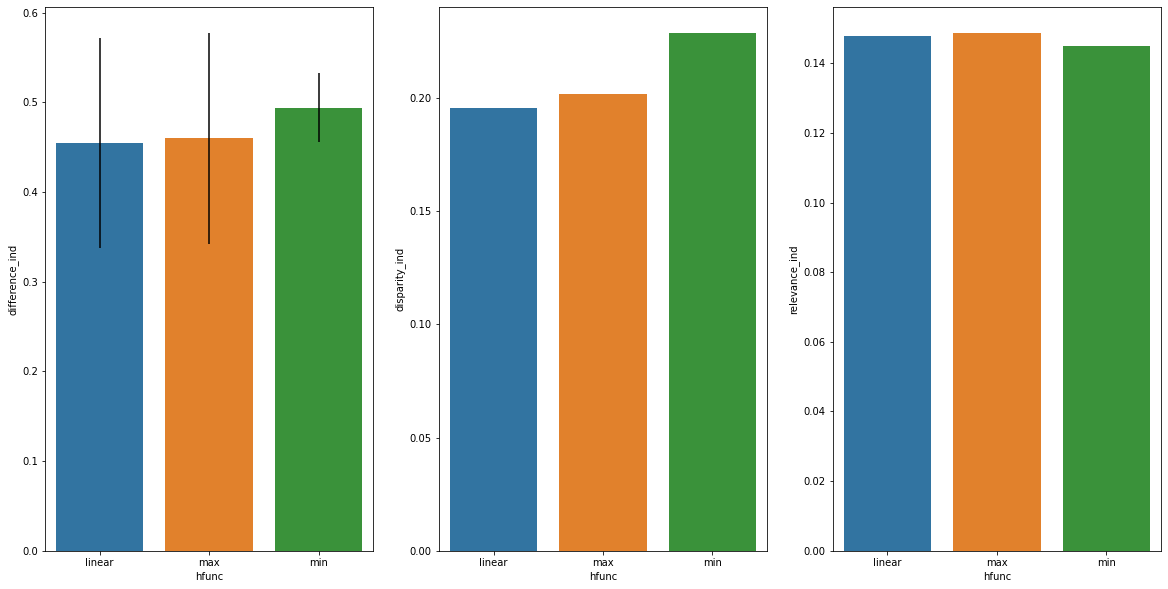

In [96]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = meta99.groupby('hfunc')
means = groups['difference_ind'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=meta99,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=meta99, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=meta99, ax=axs[2])

#### text9

In [97]:
formula = "difference ~ C(group) + C(hfunc)"
lm = ols(formula, text9).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,0.07926,0.07926,0.22371,0.63666
C(hfunc),2.00000,0.03402,0.01701,0.04801,0.95314
Residual,236.00000,83.61128,0.35429,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

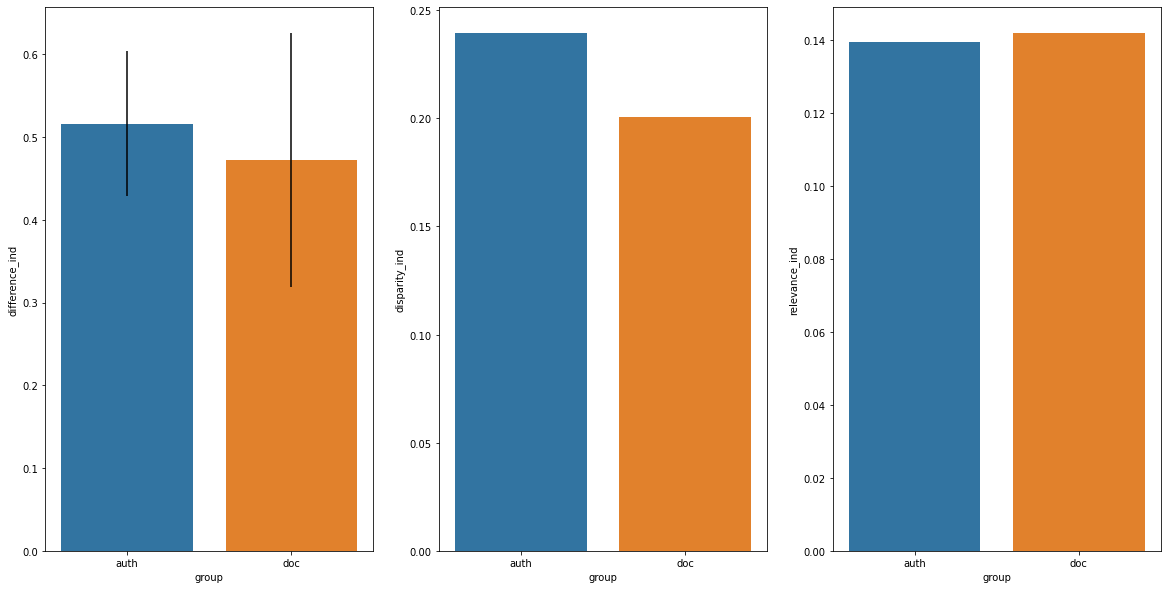

In [98]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=text9,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=text9, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=text9, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

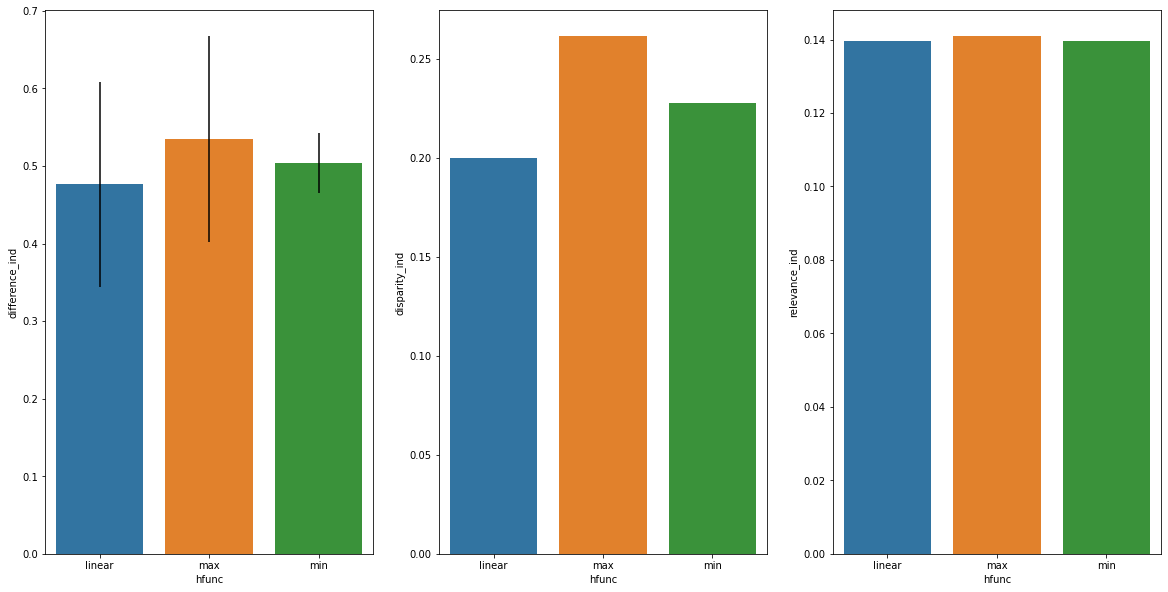

In [99]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text9.groupby('hfunc')
means = groups['difference_ind'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=text9,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=text9, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=text9, ax=axs[2])

#### text99

In [337]:
formula = "difference_ind ~ C(gr) + C(hfunc)"
lm = ols(formula, text99).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.45456,0.15152,2.31544,0.07650
C(hfunc),2.00000,0.02820,0.01410,0.21548,0.80631
Residual,234.00000,15.31287,0.06544,NaN,NaN


The influence of group and hfunc are not significant.

##### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

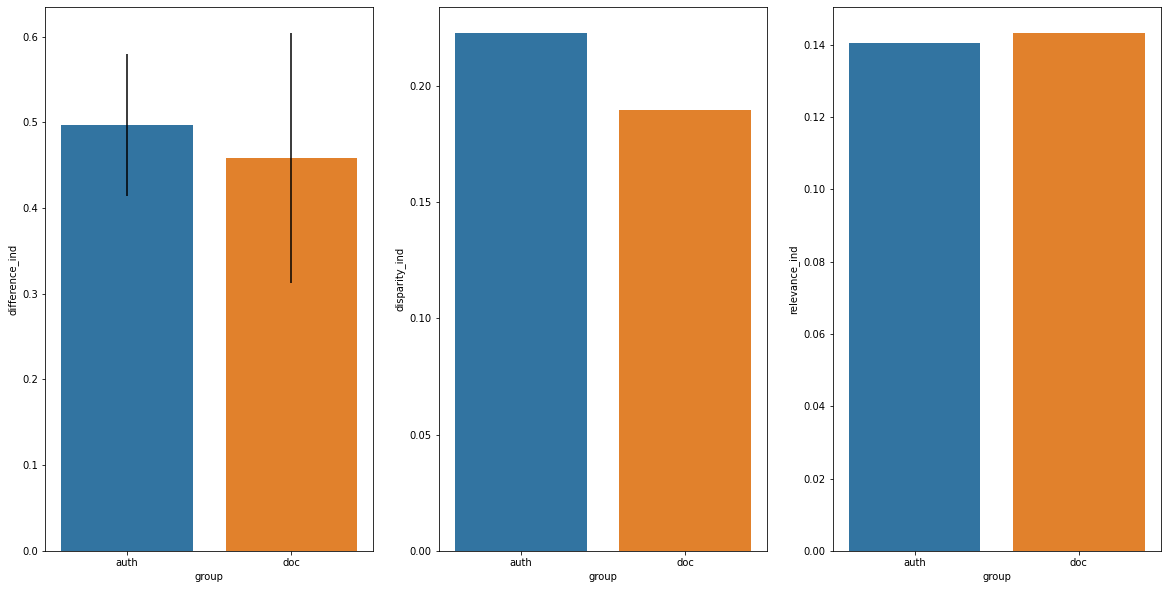

In [101]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=text99,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=text99, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=text99, ax=axs[2])


In [105]:
print(len(experiments))
len(experiments.drop_duplicates())


67280


67280

<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

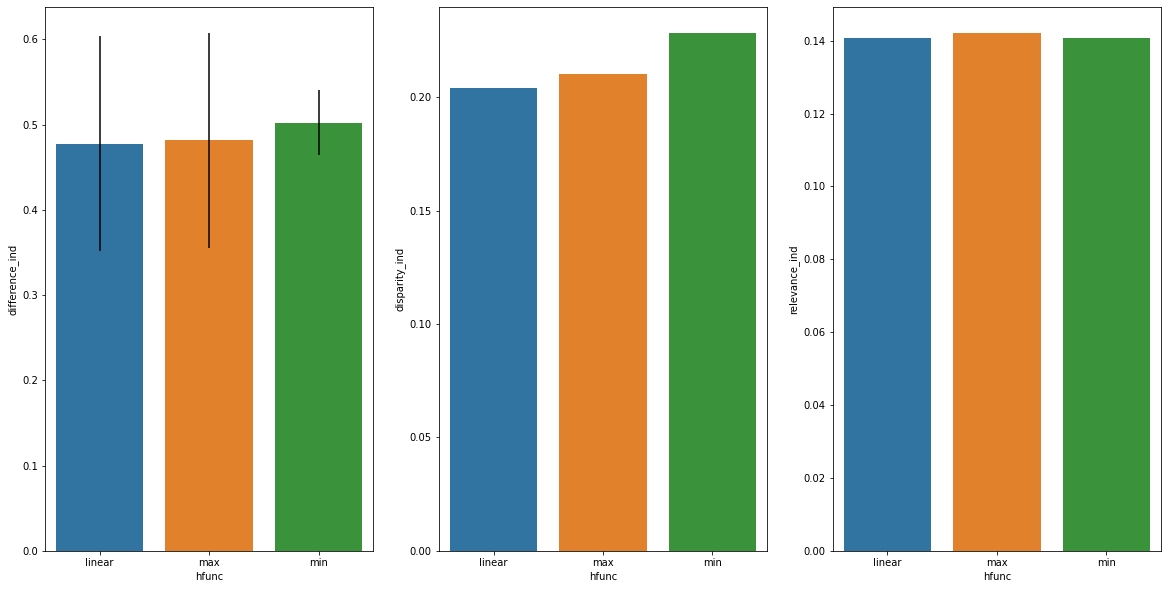

In [104]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = text99.groupby('hfunc')
means = groups['difference_ind'].mean()
m1 = means['max']
n1 = len(groups.get_group('max'))
m2 = means['min']
n2 = len(groups.get_group('min'))
m3 = means['linear']
n3 = len(groups.get_group('linear'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c2 = ci(m3, n3, ms_error)

fig, axs = plt.subplots(1,3,figsize=(20,10))

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=text99,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=text99, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=text99, ax=axs[2])

## Which pipeline configuration yields the best result? Which factors make it so?

Since the base LM config (NDCG, no augmentation, no feature selection) yields the highest fairness both for group and individual fairness, we use it as the base configuration for re-ranking.

Now we see if re-ranking significantly improves the eel and eel ind.

### ANOVA without replication main factors

In [402]:
pipeline = experiments.copy()
# pipeline = experiments[((experiments.ranker == 'ac') | (experiments.ranker == 'rfr') | (experiments.ranker == 'lambdamart'))]
pipeline.source = pipeline.source.apply(lambda row: 'lm_err' if 'err' in row else 'lm_ndcg' if 'ndcg' in row else 'KR' if 'train' in row else row)
pipeline['gr'] = pipeline.apply(lambda df: '_'.join([df.group, df.subgroup]),axis=1)
pipeline = pipeline.reset_index(drop=True)


pipeline

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,0.70095,64062,relevance_ranker,KR,-,-,-,-,-,-,-,-,-,-_-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,0.09406,66637,relevance_ranker,KR,-,-,-,-,-,-,-,-,-,-_-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,0.72625,67404,relevance_ranker,KR,-,-,-,-,-,-,-,-,-,-_-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,0.00073,70673,relevance_ranker,KR,-,-,-,-,-,-,-,-,-,-_-


## group EEL

In [403]:
formula = "difference ~ C(ranker) + C(qid)"
lm = ols(formula, pipeline).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),3.00000,434.80391,144.93464,2789.92696,0.00000
C(qid),19.00000,13105.33450,689.75445,13277.46468,0.00000
Residual,67257.00000,3493.95129,0.05195,NaN,NaN


#### ANOVA effect sizes

In [404]:
print_etasq('ranker')

ranker
eta-squared	eta-squared partial
0.02553			0.11067



#### Tukey HSD

In [405]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=pipeline['difference'], groups=pipeline['ranker'], alpha=0.05)
print(tukey)


          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
              ac       lambdamart    0.435 0.001  0.4077  0.4623   True
              ac relevance_ranker   0.4812 0.001  0.2794  0.6831   True
              ac              rfr   0.0557 0.001  0.0414    0.07   True
      lambdamart relevance_ranker   0.0462   0.9 -0.1573  0.2498  False
      lambdamart              rfr  -0.3793 0.001 -0.4091 -0.3494   True
relevance_ranker              rfr  -0.4255 0.001 -0.6277 -0.2233   True
-----------------------------------------------------------------------


#### cohen's d

In [406]:
pipeline.groupby('ranker')['difference'].mean()

ranker
ac                 0.44073
lambdamart         0.87573
relevance_ranker   0.92196
rfr                0.49646
Name: difference, dtype: float64

In [407]:
# val_metric
means = pipeline.groupby('ranker')['difference'].mean()
m1 = means['lambdamart']
m2 = means['ac']
m3 = means['rfr']
m4 = means['relevance_ranker']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))

1.9085232792321973
1.6639966934689998
0.20284396589698817
0.24452658576319752
2.1113672451291854
1.866840659365988


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [408]:
print(len(experiments))
len(experiments.drop_duplicates())


67280


67280

In [409]:
pipeline.groupby('ranker')[['difference','disparity','relevance']].mean()

,difference,disparity,relevance
ranker,,,
ac,0.44073,1.60227,1.12737
lambdamart,0.87573,2.13876,1.17812
relevance_ranker,0.92196,2.09242,1.13183
rfr,0.49646,1.69285,1.14479


<AxesSubplot:xlabel='ranker', ylabel='relevance'>

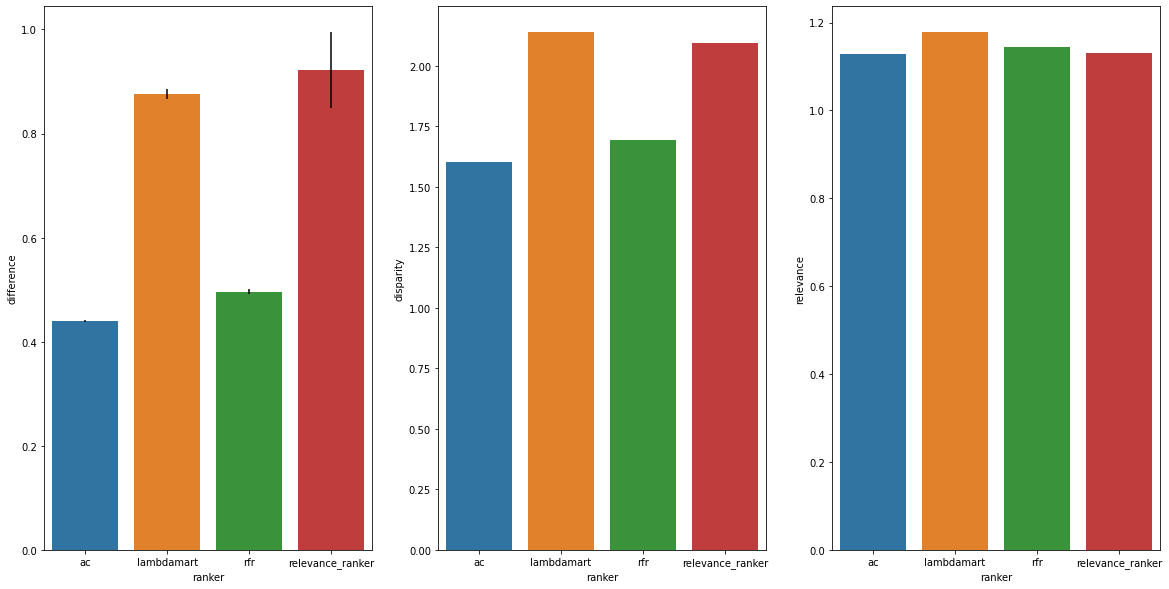

In [410]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = pipeline.groupby('ranker')
means = groups['difference'].mean()
m1 = means['ac']
n1 = len(groups.get_group('ac'))
m2 = means['lambdamart']
n2 = len(groups.get_group('lambdamart'))
m3 = means['rfr']
n3 = len(groups.get_group('rfr'))
m4 = means['relevance_ranker']
n4 = len(groups.get_group('relevance_ranker'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=pipeline,ax=axs[0])
sns.barplot(x='ranker', y='disparity', ci=None, data=pipeline, ax=axs[1])
sns.barplot(x='ranker', y='relevance', ci=None, data=pipeline, ax=axs[2])


## within AC and RFR

#### AC

In [473]:
acdata[acdata.source.str.contains('lm')].groupby('source').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid
source,,,,,,,,
lm_err,0.44370,1.61094,1.13022,0.50879,0.26816,0.15735,0.25568,39200.95000
lm_ndcg,0.43721,1.59286,1.12442,0.49678,0.26473,0.16165,0.26167,39200.95000


In [474]:
acdata = pipeline[(pipeline.ranker == 'ac')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
acdata = acdata.reset_index(drop=True)
acdata
# acdata.tail()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55675,0.27267,2.23038,1.53659,0.34305,0.16840,0.13317,0.27100,64062,ac,KR,doc,-,9.00000,min,-,-,-,-,-,doc_-
55676,0.11407,2.82126,2.27971,0.58871,0.30796,0.25111,0.25412,66637,ac,KR,doc,-,9.00000,min,-,-,-,-,-,doc_-
55677,0.30607,1.41376,1.40719,0.56222,0.30336,0.26206,0.26757,67404,ac,KR,doc,-,9.00000,min,-,-,-,-,-,doc_-
55678,0.44303,1.82916,1.15587,0.68086,0.21450,0.15797,0.15994,70673,ac,KR,doc,-,9.00000,min,-,-,-,-,-,doc_-


In [475]:
formula = 'difference ~ C(gr) + C(theta) + C(hfunc) + C(source) + C(qid)'
lm = ols(formula, acdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,17.16472,5.72157,208.00724,0.00000
C(theta),1.00000,0.09898,0.09898,3.59843,0.05784
C(hfunc),2.00000,2.49053,1.24527,45.27157,0.00000
C(source),2.00000,0.81597,0.40798,14.83217,0.00000
C(qid),19.00000,9903.26710,521.22458,18949.07285,0.00000
Residual,55652.00000,1530.79735,0.02751,NaN,NaN


#### ANOVA effect sizes

In [476]:
print_etasq('gr')
print_etasq('hfunc')
print_etasq('source')

gr
eta-squared	eta-squared partial
0.0015			0.01109

hfunc
eta-squared	eta-squared partial
0.00022			0.00162

source
eta-squared	eta-squared partial
7e-05			0.00053



#### Tukey HSD

In [477]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['gr'], alpha=0.05)
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reject
---------------------------------------------------------
 auth_ind auth_none   0.0395 0.001  0.0256  0.0535   True
 auth_ind  auth_one  -0.0006   0.9 -0.0145  0.0134  False
 auth_ind     doc_-  -0.0024   0.9 -0.0164  0.0115  False
auth_none  auth_one  -0.0401 0.001  -0.054 -0.0261   True
auth_none     doc_-  -0.0419 0.001 -0.0559  -0.028   True
 auth_one     doc_-  -0.0019   0.9 -0.0158  0.0121  False
---------------------------------------------------------


In [478]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['source'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
    KR  lm_err  -0.0127 0.6564 -0.0476 0.0222  False
    KR lm_ndcg  -0.0192 0.4039 -0.0541 0.0157  False
lm_err lm_ndcg  -0.0065 0.2154 -0.0156 0.0026  False
----------------------------------------------------


In [479]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
linear    max  -0.0009    0.9 -0.012 0.0101  False
linear    min   0.0137 0.0101 0.0027 0.0247   True
   max    min   0.0146 0.0054 0.0036 0.0257   True
--------------------------------------------------


In [480]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference'], groups=acdata['theta'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   9.0   99.0  -0.0027 0.4879 -0.0102 0.0049  False
---------------------------------------------------


#### cohen's d

In [416]:
# val_metric
means = acdata.groupby('gr')['difference'].mean()
m1 = means['auth_ind']
m2 = means['auth_none']
m3 = means['auth_one']
m4 = means['doc_-']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))



0.23822321487255657
0.23822321487255657
0.014516147867002794
0.24154081218399862
0.2527393627395594
0.011198550555560745


#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='gr', ylabel='relevance'>

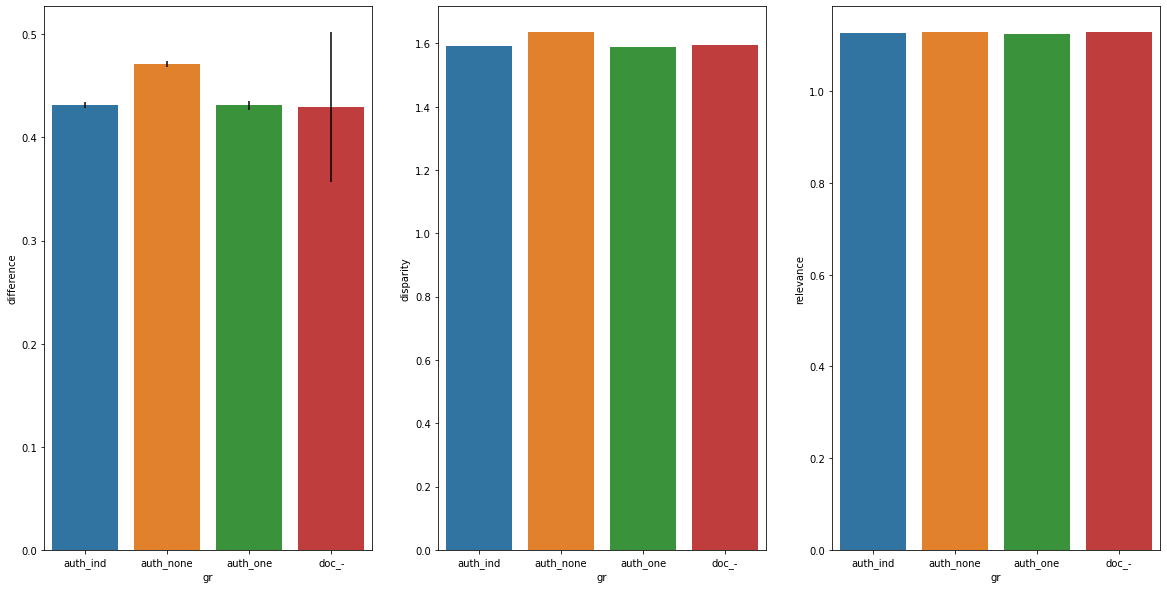

In [417]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('gr')
means = groups['difference'].mean()
m2 = means['auth_none']
n2 = len(groups.get_group('auth_none'))
m1 = means['auth_ind']
n1 = len(groups.get_group('auth_ind'))
m3 = means['auth_one']
n3 = len(groups.get_group('auth_one'))
m4 = means['doc_-']
n4 = len(groups.get_group('doc_-'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=acdata,ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data=acdata, ax=axs[2])


<AxesSubplot:xlabel='source', ylabel='relevance'>

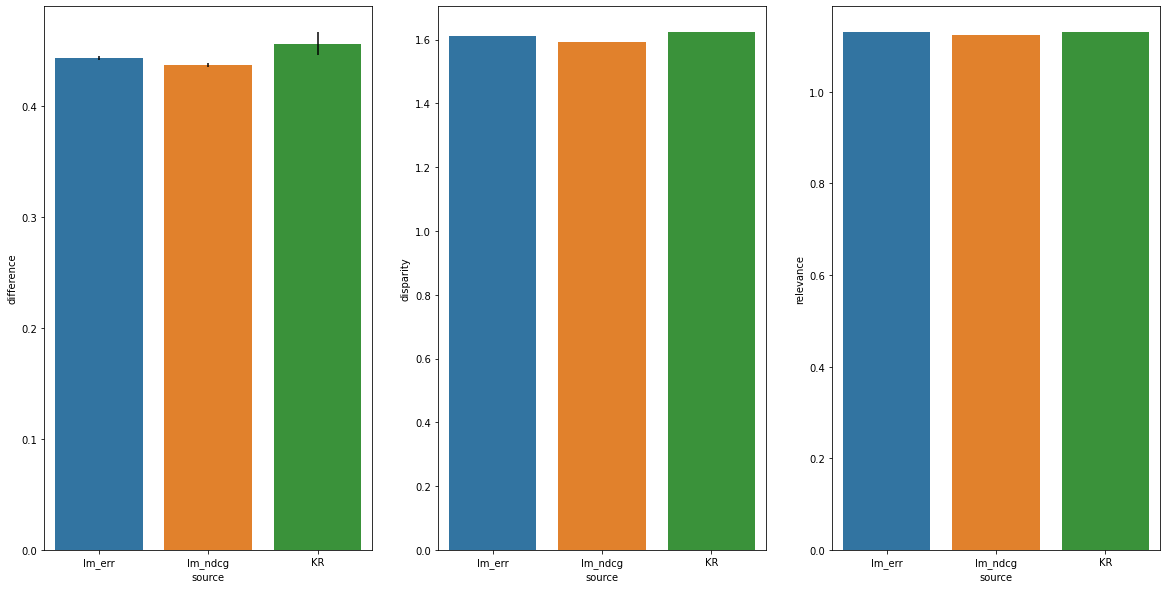

In [418]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('source')
means = groups['difference'].mean()
m3 = means['KR']
n3 = len(groups.get_group('KR'))
m1 = means['lm_err']
n1 = len(groups.get_group('lm_err'))
m2 = means['lm_ndcg']
n2 = len(groups.get_group('lm_ndcg'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference',ci=None, yerr=[c1,c2,c3], data=acdata,ax=axs[0])
sns.barplot(x='source', y='disparity', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='source', y='relevance', ci=None, data=acdata, ax=axs[2])


## RFR

In [419]:
rfrdata = pipeline[(pipeline.ranker == 'rfr')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
rfrdata = rfrdata.reset_index(drop=True)
rfrdata
# acdata.tail()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.26012,2.10448,1.47887,0.60632,0.21770,0.02618,0.05397,3462,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
1,0.34971,1.20178,0.87162,0.89402,0.44894,0.16895,0.15925,8940,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
2,0.08718,1.81759,1.46991,0.41983,0.19549,0.06526,0.16945,10795,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
3,0.23108,1.23185,0.83096,0.23622,0.15254,0.03897,0.22137,12073,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
4,0.07800,2.28155,1.96805,0.89482,0.32398,0.10562,0.10353,12096,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9275,0.40215,2.44150,1.57741,0.37459,0.25719,0.16179,0.32274,64062,rfr,KR,doc,-,-,-,-,-,-,-,-,doc_-
9276,0.15078,3.05905,2.38025,0.60998,0.48356,0.32828,0.33026,66637,rfr,KR,doc,-,-,-,-,-,-,-,-,doc_-
9277,0.05044,1.88490,1.77058,0.49515,0.49544,0.39164,0.41182,67404,rfr,KR,doc,-,-,-,-,-,-,-,-,doc_-
9278,0.25197,1.61310,1.14338,0.81935,0.29038,0.12666,0.12166,70673,rfr,KR,doc,-,-,-,-,-,-,-,-,doc_-


In [420]:
formula = 'difference ~ C(gr) + C(source) + C(qid)'
lm = ols(formula, rfrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,11.57131,3.85710,71.48385,0.00000
C(source),2.00000,1.12601,0.56300,10.43417,0.00003
C(qid),19.00000,3517.37040,185.12476,3430.92484,0.00000
Residual,9255.00000,499.37836,0.05396,NaN,NaN


#### ANOVA effect sizes

In [421]:
print_etasq('gr')
print_etasq('source')

gr
eta-squared	eta-squared partial
0.00287			0.02265

source
eta-squared	eta-squared partial
0.00028			0.00225



#### Tukey HSD

In [422]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference'], groups=rfrdata['gr'], alpha=0.05)
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reject
---------------------------------------------------------
 auth_ind auth_none  -0.0008   0.9 -0.0505  0.0488  False
 auth_ind  auth_one    0.006   0.9 -0.0436  0.0557  False
 auth_ind     doc_-  -0.0796 0.001 -0.1292 -0.0299   True
auth_none  auth_one   0.0069   0.9 -0.0428  0.0565  False
auth_none     doc_-  -0.0787 0.001 -0.1284 -0.0291   True
 auth_one     doc_-  -0.0856 0.001 -0.1353  -0.036   True
---------------------------------------------------------


In [423]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference'], groups=rfrdata['source'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
    KR  lm_err  -0.0719 0.3655 -0.1961 0.0524  False
    KR lm_ndcg  -0.0813 0.2754 -0.2056 0.0429  False
lm_err lm_ndcg  -0.0095 0.7517 -0.0418 0.0229  False
----------------------------------------------------


#### cohen's d

In [424]:
rfrdata.groupby('source')['difference'].mean()

source
KR        0.57173
lm_err    0.49987
lm_ndcg   0.49042
Name: difference, dtype: float64

In [425]:
# val_metric
means = rfrdata.groupby('gr')['difference'].mean()
m1 = means['auth_none']
m2 = means['auth_one']
m3 = means['auth_ind']
m4 = means['doc_-']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))


0.02967290310353387
0.0036478378192420944
0.3389641672902694
0.026025065284291774
0.3686370703938033
0.3426120051095115


#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='gr', ylabel='relevance'>

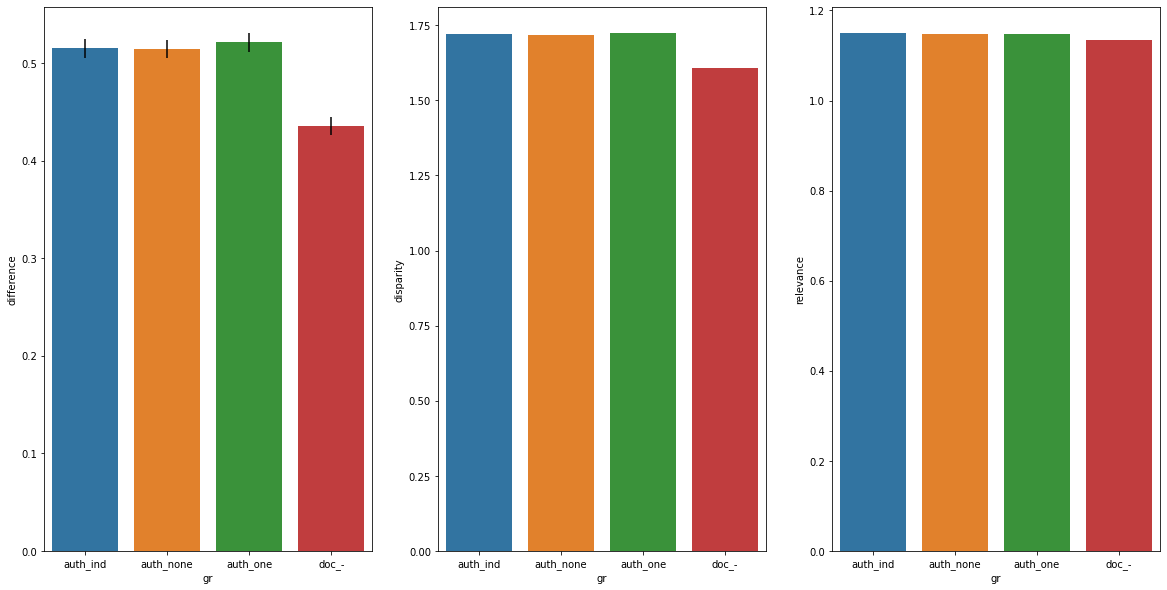

In [426]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('gr')
means = groups['difference'].mean()
m2 = means['auth_none']
n2 = len(groups.get_group('auth_none'))
m1 = means['auth_ind']
n1 = len(groups.get_group('auth_ind'))
m3 = means['auth_one']
n3 = len(groups.get_group('auth_one'))
m4 = means['doc_-']
n4 = len(groups.get_group('doc_-'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='gr', y='difference',ci=None, yerr=[c1,c2,c3,c4], data=rfrdata,ax=axs[0])
sns.barplot(x='gr', y='disparity', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='gr', y='relevance', ci=None, data=rfrdata, ax=axs[2])


<AxesSubplot:xlabel='source', ylabel='relevance'>

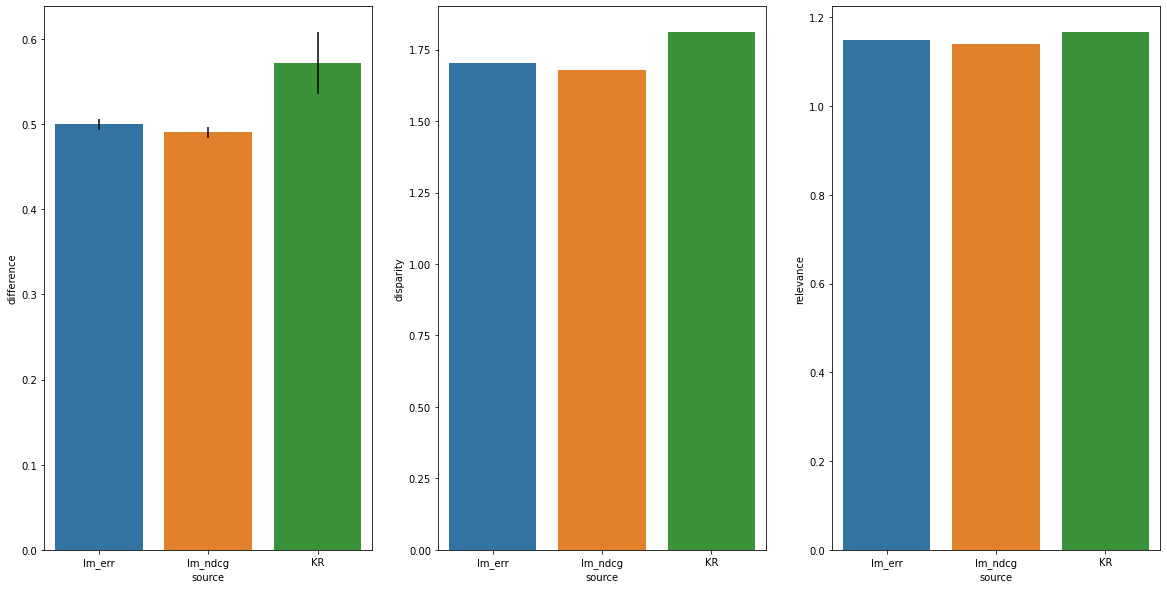

In [429]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('source')
means = groups['difference'].mean()
m3 = means['KR']
n3 = len(groups.get_group('KR'))
m1 = means['lm_err']
n1 = len(groups.get_group('lm_err'))
m2 = means['lm_ndcg']
n2 = len(groups.get_group('lm_ndcg'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference',ci=None, yerr=[c1,c2,c3], data=rfrdata,ax=axs[0])
sns.barplot(x='source', y='disparity', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='source', y='relevance', ci=None, data=rfrdata, ax=axs[2])


## ind EEL

In [430]:
formula = "difference_ind ~ C(ranker) + C(qid)"
lm = ols(formula, pipeline).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),3.00000,1993.19974,664.39991,33878.54649,0.00000
C(qid),19.00000,3464.46388,182.34020,9297.74518,0.00000
Residual,67257.00000,1318.99239,0.01961,NaN,NaN


#### ANOVA effect sizes

In [431]:
print_etasq('ranker')

ranker
eta-squared	eta-squared partial
0.29413			0.60178



#### Tukey HSD

In [432]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=pipeline['difference_ind'], groups=pipeline['ranker'], alpha=0.05)
print(tukey)


          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
              ac       lambdamart    0.944 0.001  0.9293  0.9586   True
              ac relevance_ranker   0.9253 0.001   0.817  1.0337   True
              ac              rfr   0.0729 0.001  0.0653  0.0806   True
      lambdamart relevance_ranker  -0.0186   0.9 -0.1279  0.0906  False
      lambdamart              rfr   -0.871 0.001  -0.887  -0.855   True
relevance_ranker              rfr  -0.8524 0.001  -0.961 -0.7439   True
-----------------------------------------------------------------------


#### cohen's d

In [433]:
pipeline.groupby('ranker')['difference_ind'].mean()

ranker
ac                 0.50255
lambdamart         1.44652
relevance_ranker   1.42789
rfr                0.57549
Name: difference_ind, dtype: float64

In [434]:
# val_metric
means = pipeline.groupby('ranker')['difference_ind'].mean()
m1 = means['lambdamart']
m2 = means['ac']
m3 = means['rfr']
m4 = means['relevance_ranker']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))

6.7407384143063585
6.219884846907633
0.13302570194957627
0.520853567398725
6.607712712356782
6.086859144958058


#### Visualize performance in term of difference, disparity, relevance + bar charts

In [435]:
print(len(experiments))
len(experiments.drop_duplicates())


67280


67280

In [436]:
pipeline.groupby('ranker')[['difference_ind','disparity_ind','relevance_ind']].mean()

,difference_ind,disparity_ind,relevance_ind
ranker,,,
ac,0.50255,0.26565,0.15922
lambdamart,1.44652,1.26102,0.18492
relevance_ranker,1.42789,1.25077,0.18911
rfr,0.57549,0.29947,0.13966


<AxesSubplot:xlabel='ranker', ylabel='relevance_ind'>

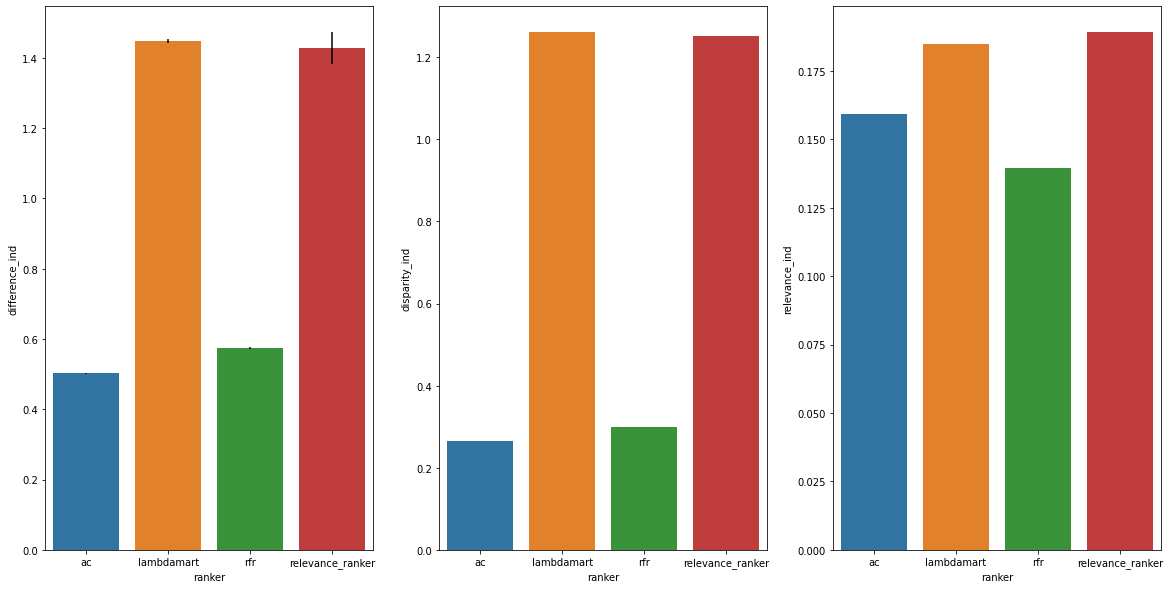

In [437]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = pipeline.groupby('ranker')
means = groups['difference_ind'].mean()
m1 = means['ac']
n1 = len(groups.get_group('ac'))
m2 = means['lambdamart']
n2 = len(groups.get_group('lambdamart'))
m3 = means['rfr']
n3 = len(groups.get_group('rfr'))
m4 = means['relevance_ranker']
n4 = len(groups.get_group('relevance_ranker'))
c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='ranker', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data=pipeline,ax=axs[0])
sns.barplot(x='ranker', y='disparity_ind', ci=None, data=pipeline, ax=axs[1])
sns.barplot(x='ranker', y='relevance_ind', ci=None, data=pipeline, ax=axs[2])


## within AC and RFR

#### AC

In [438]:
acdata = pipeline[(pipeline.ranker == 'ac')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
acdata = acdata.reset_index(drop=True)
acdata
# acdata.tail()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,0.12853,3462,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,0.21435,8940,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,0.23099,10795,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,0.22568,12073,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,0.13237,12096,ac,lm_err,auth,ind,99.00000,linear,-,-,-,-,-,auth_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55675,0.27267,2.23038,1.53659,0.34305,0.16840,0.13317,0.27100,64062,ac,KR,doc,-,9.00000,min,-,-,-,-,-,doc_-
55676,0.11407,2.82126,2.27971,0.58871,0.30796,0.25111,0.25412,66637,ac,KR,doc,-,9.00000,min,-,-,-,-,-,doc_-
55677,0.30607,1.41376,1.40719,0.56222,0.30336,0.26206,0.26757,67404,ac,KR,doc,-,9.00000,min,-,-,-,-,-,doc_-
55678,0.44303,1.82916,1.15587,0.68086,0.21450,0.15797,0.15994,70673,ac,KR,doc,-,9.00000,min,-,-,-,-,-,doc_-


In [439]:
formula = 'difference_ind ~ C(gr) + C(theta) + C(hfunc) + C(source) + C(qid)'
lm = ols(formula, acdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,26.80634,8.93545,893.44968,0.00000
C(theta),1.00000,7.59998,7.59998,759.91683,0.00000
C(hfunc),2.00000,8.00319,4.00159,400.11678,0.00000
C(source),2.00000,2.15729,1.07865,107.85321,0.00000
C(qid),19.00000,2707.34088,142.49163,14247.64744,0.00000
Residual,55652.00000,556.57918,0.01000,NaN,NaN


#### ANOVA effect sizes

In [440]:
print_etasq('gr')
print_etasq('hfunc')
print_etasq('source')
print_etasq('theta')

gr
eta-squared	eta-squared partial
0.0081			0.04595

hfunc
eta-squared	eta-squared partial
0.00242			0.01418

source
eta-squared	eta-squared partial
0.00065			0.00386

theta
eta-squared	eta-squared partial
0.0023			0.01347



#### Tukey HSD

In [441]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['gr'], alpha=0.05)
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
 auth_ind auth_none   0.0495  0.001  0.0421   0.057   True
 auth_ind  auth_one   0.0004    0.9 -0.0071  0.0079  False
 auth_ind     doc_-  -0.0034 0.6198 -0.0109   0.004  False
auth_none  auth_one  -0.0492  0.001 -0.0566 -0.0417   True
auth_none     doc_-   -0.053  0.001 -0.0605 -0.0455   True
 auth_one     doc_-  -0.0038 0.5461 -0.0113  0.0036  False
----------------------------------------------------------


In [442]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['source'], alpha=0.05)
print(tukey)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
    KR  lm_err     0.02 0.0336  0.0012  0.0387   True
    KR lm_ndcg    0.008 0.5741 -0.0108  0.0267  False
lm_err lm_ndcg   -0.012  0.001 -0.0169 -0.0071   True
-----------------------------------------------------


In [443]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
linear    max    0.001   0.9 -0.005 0.0069  False
linear    min   0.0259 0.001   0.02 0.0318   True
   max    min   0.0249 0.001  0.019 0.0309   True
-------------------------------------------------


In [444]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acdata['difference_ind'], groups=acdata['theta'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   9.0   99.0   0.0234 0.001 0.0193 0.0274   True
-------------------------------------------------


#### cohen's d

In [445]:
# val_metric
means = acdata.groupby('gr')['difference_ind'].mean()
m1 = means['auth_ind']
m2 = means['auth_none']
m3 = means['auth_one']
m4 = means['doc_-']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m2, ms_error))


0.4952947124603536
0.4952947124603536
0.4952947124603536


In [447]:
# val_metric
means = acdata.groupby('source')['difference_ind'].mean()
m1 = means['KR']
m2 = means['lm_ndcg']
m3 = means['lm_err']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))


0.07963968152060216
0.19973273471994235
0.01337233536432048
0.12009305319934019


In [448]:
# val_metric
means = acdata.groupby('hfunc')['difference'].mean()
m1 = means['linear']
m2 = means['min']
m3 = means['max']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))



0.13706325042312814
0.00916230273516087
0.146225553158289


In [449]:
# val_metric
means = acdata.groupby('theta')['difference'].mean()
m1 = means[9]
m2 = means[99]

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))


0.026664435052031515


#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='group', ylabel='relevance_ind'>

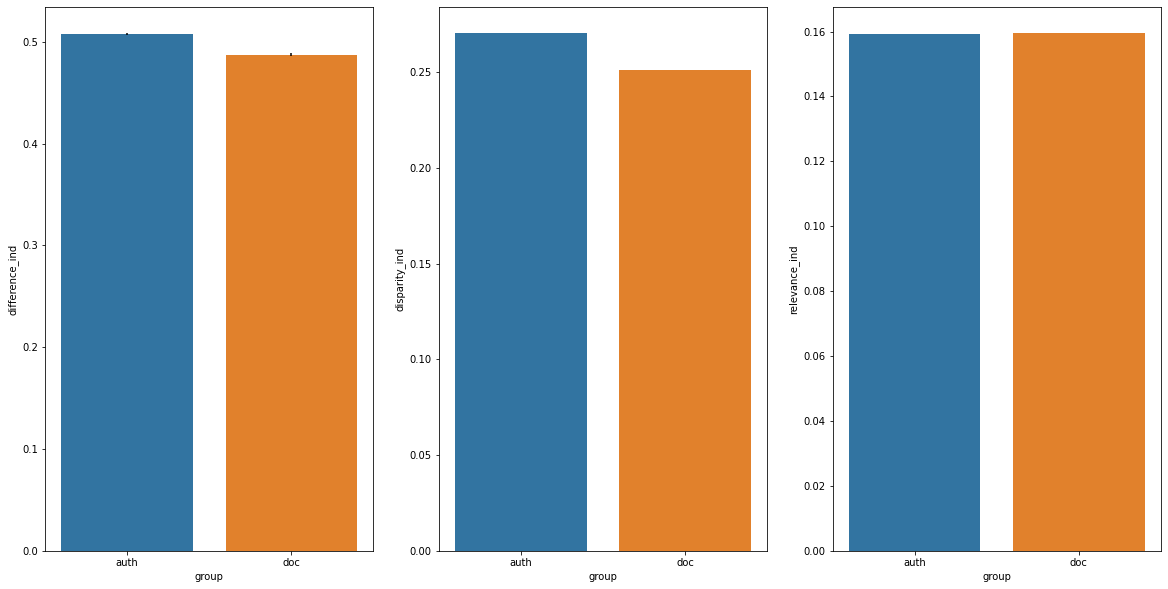

In [450]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('group')
means = groups['difference_ind'].mean()
m1 = means['auth']
n1 = len(groups.get_group('auth'))
m2 = means['doc']
n2 = len(groups.get_group('doc'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='group', y='difference_ind',ci=None, yerr=[c1,c2], data=acdata,ax=axs[0])
sns.barplot(x='group', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='group', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


<AxesSubplot:xlabel='source', ylabel='relevance_ind'>

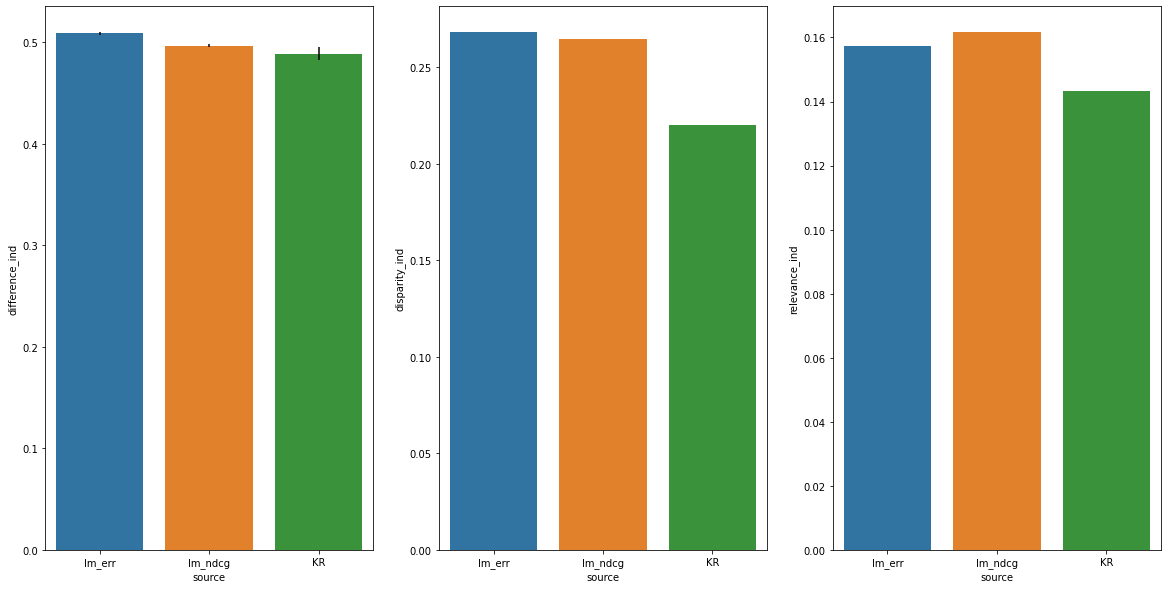

In [451]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('source')
means = groups['difference_ind'].mean()
m3 = means['KR']
n3 = len(groups.get_group('KR'))
m1 = means['lm_err']
n1 = len(groups.get_group('lm_err'))
m2 = means['lm_ndcg']
n2 = len(groups.get_group('lm_ndcg'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=acdata,ax=axs[0])
sns.barplot(x='source', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='source', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


<AxesSubplot:xlabel='hfunc', ylabel='relevance_ind'>

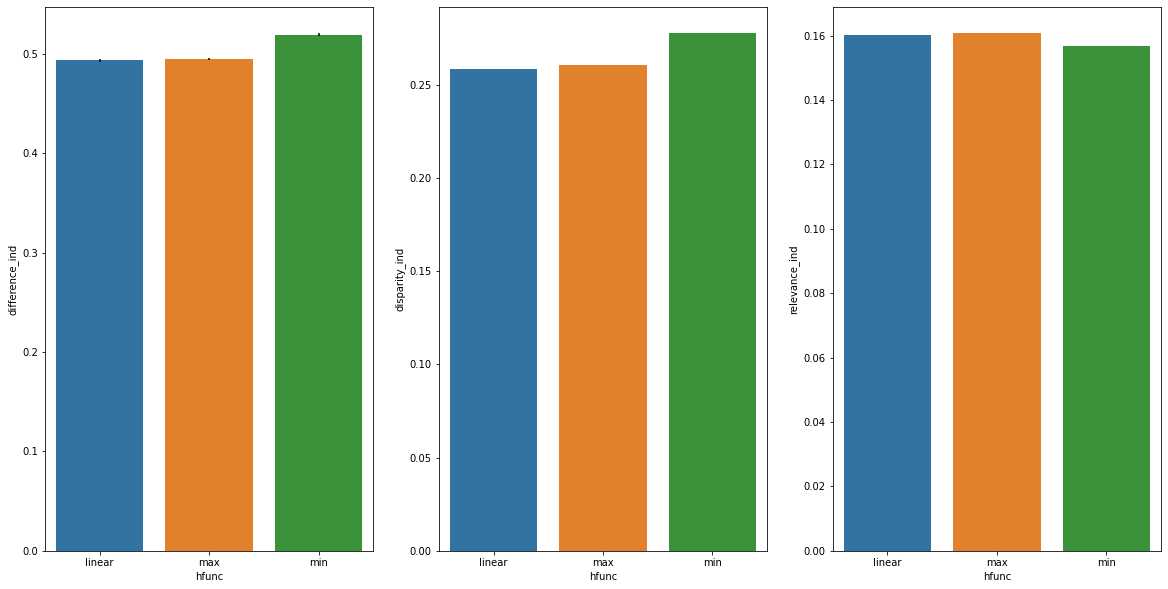

In [452]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('hfunc')
means = groups['difference_ind'].mean()
m3 = means['linear']
n3 = len(groups.get_group('linear'))
m4 = means['max']
n4 = len(groups.get_group('max'))
m1 = means['min']
n1 = len(groups.get_group('min'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='hfunc', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=acdata,ax=axs[0])
sns.barplot(x='hfunc', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='hfunc', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


<AxesSubplot:xlabel='theta', ylabel='relevance_ind'>

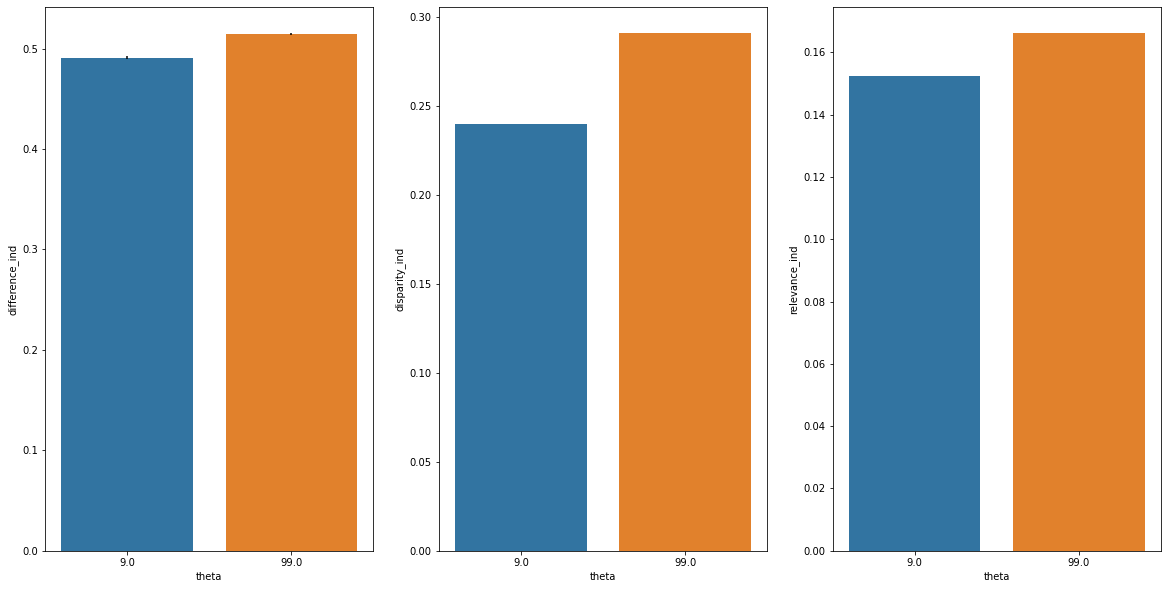

In [453]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = acdata.groupby('theta')
means = groups['difference_ind'].mean()
m3 = means[9]
n3 = len(groups.get_group(9))
m4 = means[99]
n4 = len(groups.get_group(99))


c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='theta', y='difference_ind',ci=None, yerr=[c1,c2], data=acdata,ax=axs[0])
sns.barplot(x='theta', y='disparity_ind', ci=None, data=acdata, ax=axs[1])
sns.barplot(x='theta', y='relevance_ind', ci=None, data=acdata, ax=axs[2])


## RFR

In [454]:
rfrdata = pipeline[(pipeline.ranker == 'rfr')]

# acdata.source = acdata.source.apply(lambda x: 'KR' if '_train' in x else 'lambdamart')
rfrdata = rfrdata.reset_index(drop=True)
rfrdata
# acdata.tail()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.26012,2.10448,1.47887,0.60632,0.21770,0.02618,0.05397,3462,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
1,0.34971,1.20178,0.87162,0.89402,0.44894,0.16895,0.15925,8940,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
2,0.08718,1.81759,1.46991,0.41983,0.19549,0.06526,0.16945,10795,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
3,0.23108,1.23185,0.83096,0.23622,0.15254,0.03897,0.22137,12073,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
4,0.07800,2.28155,1.96805,0.89482,0.32398,0.10562,0.10353,12096,rfr,lm_err,auth,ind,-,-,-,-,-,-,-,auth_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9275,0.40215,2.44150,1.57741,0.37459,0.25719,0.16179,0.32274,64062,rfr,KR,doc,-,-,-,-,-,-,-,-,doc_-
9276,0.15078,3.05905,2.38025,0.60998,0.48356,0.32828,0.33026,66637,rfr,KR,doc,-,-,-,-,-,-,-,-,doc_-
9277,0.05044,1.88490,1.77058,0.49515,0.49544,0.39164,0.41182,67404,rfr,KR,doc,-,-,-,-,-,-,-,-,doc_-
9278,0.25197,1.61310,1.14338,0.81935,0.29038,0.12666,0.12166,70673,rfr,KR,doc,-,-,-,-,-,-,-,-,doc_-


In [455]:
formula = 'difference_ind ~ C(group) + C(source) + C(qid)'
lm = ols(formula, rfrdata).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.00000,17.21941,17.21941,1132.93943,0.00000
C(source),2.00000,5.04139,2.52070,165.84746,0.00000
C(qid),19.00000,820.49129,43.18375,2841.24576,0.00000
Residual,9257.00000,140.69603,0.01520,NaN,NaN


#### ANOVA effect sizes

In [456]:
print_etasq('group')
print_etasq('source')

group
eta-squared	eta-squared partial
0.01751			0.10904

source
eta-squared	eta-squared partial
0.00513			0.03459



#### Tukey HSD

In [457]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference_ind'], groups=rfrdata['group'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  auth    doc  -0.0995 0.001 -0.1146 -0.0843   True
---------------------------------------------------


In [458]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference_ind'], groups=rfrdata['source'], alpha=0.05)
print(tukey)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
    KR  lm_err  -0.1575  0.001 -0.2188 -0.0963   True
    KR lm_ndcg   -0.175  0.001 -0.2362 -0.1138   True
lm_err lm_ndcg  -0.0175 0.0278 -0.0334 -0.0015   True
-----------------------------------------------------


#### cohen's d

In [459]:
rfrdata.groupby('source')['difference_ind'].mean()

source
KR        0.73888
lm_err    0.58135
lm_ndcg   0.56389
Name: difference_ind, dtype: float64

In [460]:
# val_metric
means = rfrdata.groupby('gr')['difference_ind'].mean()
m1 = means['auth_none']
m2 = means['auth_one']
m3 = means['auth_ind']
m4 = means['doc_-']

ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m1, m4, ms_error))
print(cohens_d(m2, m3, ms_error))
print(cohens_d(m2, m4, ms_error))
print(cohens_d(m3, m4, ms_error))

0.029191810218822837
0.005341826626747237
0.7954055227028547
0.023849983592075602
0.8245973329216775
0.8007473493296019


In [462]:
# val_metric
means = rfrdata.groupby('source')['difference_ind'].mean()
m1 = means['KR']
m2 = means['lm_err']
m3 = means['lm_ndcg']


ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


1.277805288090984
1.4194041917264488
0.1415989036354649


#### Visualize performance in term of difference, disparity, relevance + bar charts

<AxesSubplot:xlabel='gr', ylabel='relevance_ind'>

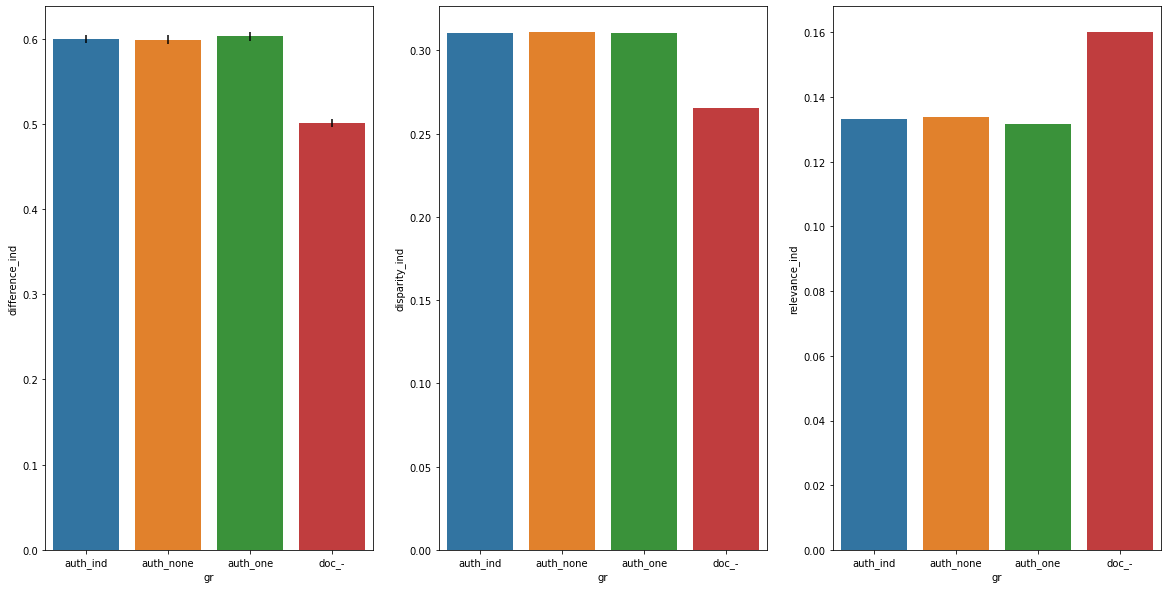

In [461]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('gr')
means = groups['difference_ind'].mean()
m2 = means['auth_none']
n2 = len(groups.get_group('auth_none'))
m1 = means['auth_ind']
n1 = len(groups.get_group('auth_ind'))
m3 = means['auth_one']
n3 = len(groups.get_group('auth_one'))
m4 = means['doc_-']
n4 = len(groups.get_group('doc_-'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)
c4 = ci(m4, n4, ms_error)



fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='gr', y='difference_ind',ci=None, yerr=[c1,c2,c3,c4], data=rfrdata,ax=axs[0])
sns.barplot(x='gr', y='disparity_ind', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='gr', y='relevance_ind', ci=None, data=rfrdata, ax=axs[2])


<AxesSubplot:xlabel='source', ylabel='relevance_ind'>

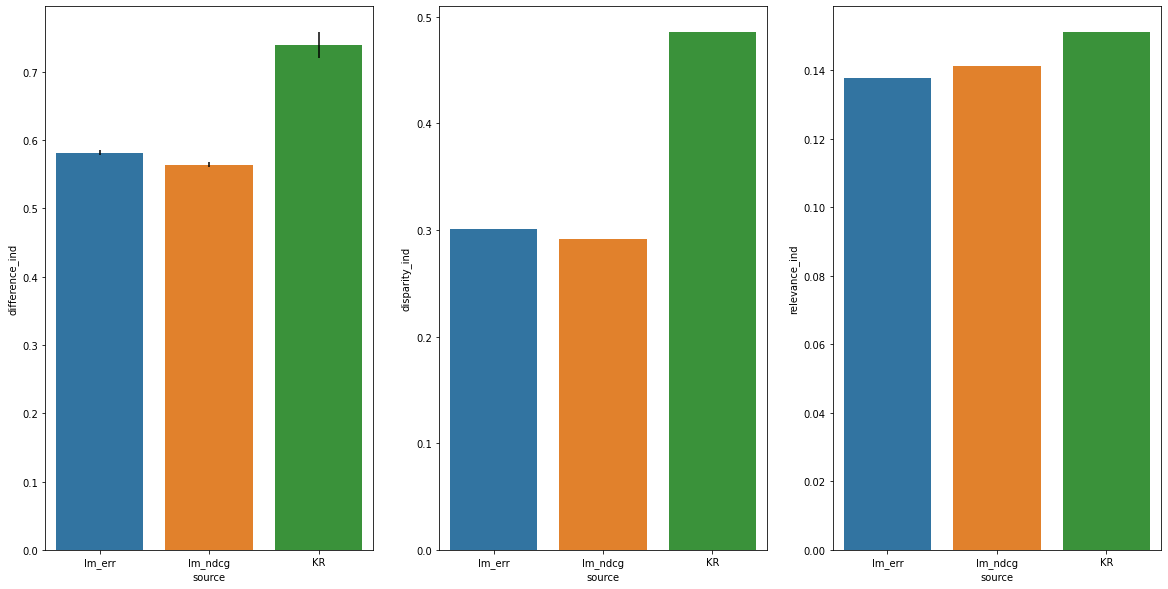

In [464]:
ms_error = anova_lm(lm).mean_sq.loc['Residual']
groups = rfrdata.groupby('source')
means = groups['difference_ind'].mean()
m3 = means['KR']
n3 = len(groups.get_group('KR'))
m1 = means['lm_err']
n1 = len(groups.get_group('lm_err'))
m2 = means['lm_ndcg']
n2 = len(groups.get_group('lm_ndcg'))

c1 = ci(m1, n1, ms_error)
c2 = ci(m2, n2, ms_error)
c3 = ci(m3, n3, ms_error)


fig, axs = plt.subplots(1,3,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',ci=None, yerr=[c1,c2,c3], data=rfrdata,ax=axs[0])
sns.barplot(x='source', y='disparity_ind', ci=None, data=rfrdata, ax=axs[1])
sns.barplot(x='source', y='relevance_ind', ci=None, data=rfrdata, ax=axs[2])


# jffffffffffffffffffffffffffffffffff

In [465]:

formula = 'difference ~ C(source) + C(qid)'
lm = ols(formula, experiments[experiments.ranker == 'relevance_ranker']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(source),1.00000,0.14425,0.14425,1.04523,0.31945
C(qid),19.00000,17.48046,0.92002,6.66668,0.00006
Residual,19.00000,2.62207,0.13800,NaN,NaN


In [386]:

formula = 'difference_ind ~ C(source) + C(qid)'
lm = ols(formula, experiments[experiments.ranker == 'relevance_ranker']).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(source),1.00000,0.00439,0.00439,0.16147,0.69229
C(qid),19.00000,8.85765,0.46619,17.15078,0.00000
Residual,19.00000,0.51646,0.02718,NaN,NaN


In [391]:
temp = experiments[(experiments.ranker == 'relevance_ranker') |(experiments.ranker == 'lambdamart') ]
temp['s'] = temp.apply(lambda df: df.source if 'train' in df.source else df.val_metric, axis =1)
temp

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,util,qid,ranker,source,...,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr,s
55680,0.21168,1.96463,1.43316,1.68645,1.32943,0.04198,0.08750,3462,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,err
55681,1.07183,2.17346,0.99640,1.90473,1.32943,0.10384,0.08791,8940,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,err
55682,0.69834,3.45495,1.98301,1.53864,1.31771,0.06697,0.17542,10795,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,err
55683,0.80910,1.65976,0.75591,1.46067,1.32943,0.01519,0.08762,12073,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,err
55684,0.24675,2.39058,1.93819,2.07945,1.33332,0.01797,0.00548,12096,lambdamart,-,...,-,-,-,aug0.5,err,mpt,10,0.1,-_-,err
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,0.70095,64062,relevance_ranker,TEXT_train,...,-,-,-,-,-,-,-,-,-_-,TEXT_train
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,0.09406,66637,relevance_ranker,TEXT_train,...,-,-,-,-,-,-,-,-,-_-,TEXT_train
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,0.72625,67404,relevance_ranker,TEXT_train,...,-,-,-,-,-,-,-,-,-_-,TEXT_train
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,0.00073,70673,relevance_ranker,TEXT_train,...,-,-,-,-,-,-,-,-,-_-,TEXT_train


In [392]:

formula = 'difference ~ C(s) + C(qid)'
lm = ols(formula, temp).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(s),3.00000,2.37729,0.79243,2.66048,0.04665
C(qid),19.00000,428.74362,22.56545,75.76039,0.00000
Residual,2297.00000,684.16817,0.29785,NaN,NaN


In [393]:

formula = 'difference_ind ~ C(s) + C(qid)'
lm = ols(formula, temp).fit()
lm.summary()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(s),3.00000,4.23514,1.41171,10.24062,0.00000
C(qid),19.00000,170.64864,8.98151,65.15221,0.00000
Residual,2297.00000,316.65116,0.13785,NaN,NaN


In [394]:
def tuke(data,dv,iv):
    tukey = pairwise_tukeyhsd(endog=data[dv], groups=data[iv], alpha=0.05)
    print(tukey)


In [395]:
tuke(temp,'difference','s')

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
META_train TEXT_train   0.1201    0.9 -0.4435 0.6837  False
META_train        err   0.0445    0.9 -0.3575 0.4465  False
META_train       ndcg  -0.0169    0.9 -0.4189 0.3851  False
TEXT_train        err  -0.0756    0.9 -0.4776 0.3264  False
TEXT_train       ndcg   -0.137 0.7934  -0.539  0.265  False
       err       ndcg  -0.0614 0.1487  -0.136 0.0132  False
-----------------------------------------------------------


In [396]:
tuke(temp,'difference_ind','s')

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
META_train TEXT_train   -0.021   0.9 -0.3939   0.352  False
META_train        err   0.0512   0.9 -0.2148  0.3172  False
META_train       ndcg  -0.0349   0.9 -0.3008  0.2311  False
TEXT_train        err   0.0721 0.894 -0.1939  0.3381  False
TEXT_train       ndcg  -0.0139   0.9 -0.2799  0.2521  False
       err       ndcg   -0.086 0.001 -0.1354 -0.0366   True
-----------------------------------------------------------


# Eval